# Laboratorium 9. Wizja Komputerowa

**Uwaga:** Poniższy notebook jest stworzony z myślą o odpalaniu go w [Colaboratory](https://colab.research.google.com/), oznacza to, że przygotowane zadania zakładają uczenie modelu z użyciem GPU. Na zajęciach zostanie krótko omówione używanie Colaboratory. Na własną odpowiedzialność można używać własnego komputera do rozwiązania zadań domowych.

In [12]:
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose, Lambda, RandomCrop, RandomHorizontalFlip, TenCrop, RandomRotation, Scale, RandomAffine
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

### CIFAR10
[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) to dataset zawierający 60 tysięcy kolorowych obrazków rozmiaru 32 $\times$ 32 pikseli należących do 10 różnych klas. Poniżej przykładowe wizualizacje.

Files already downloaded and verified
CIFAR10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


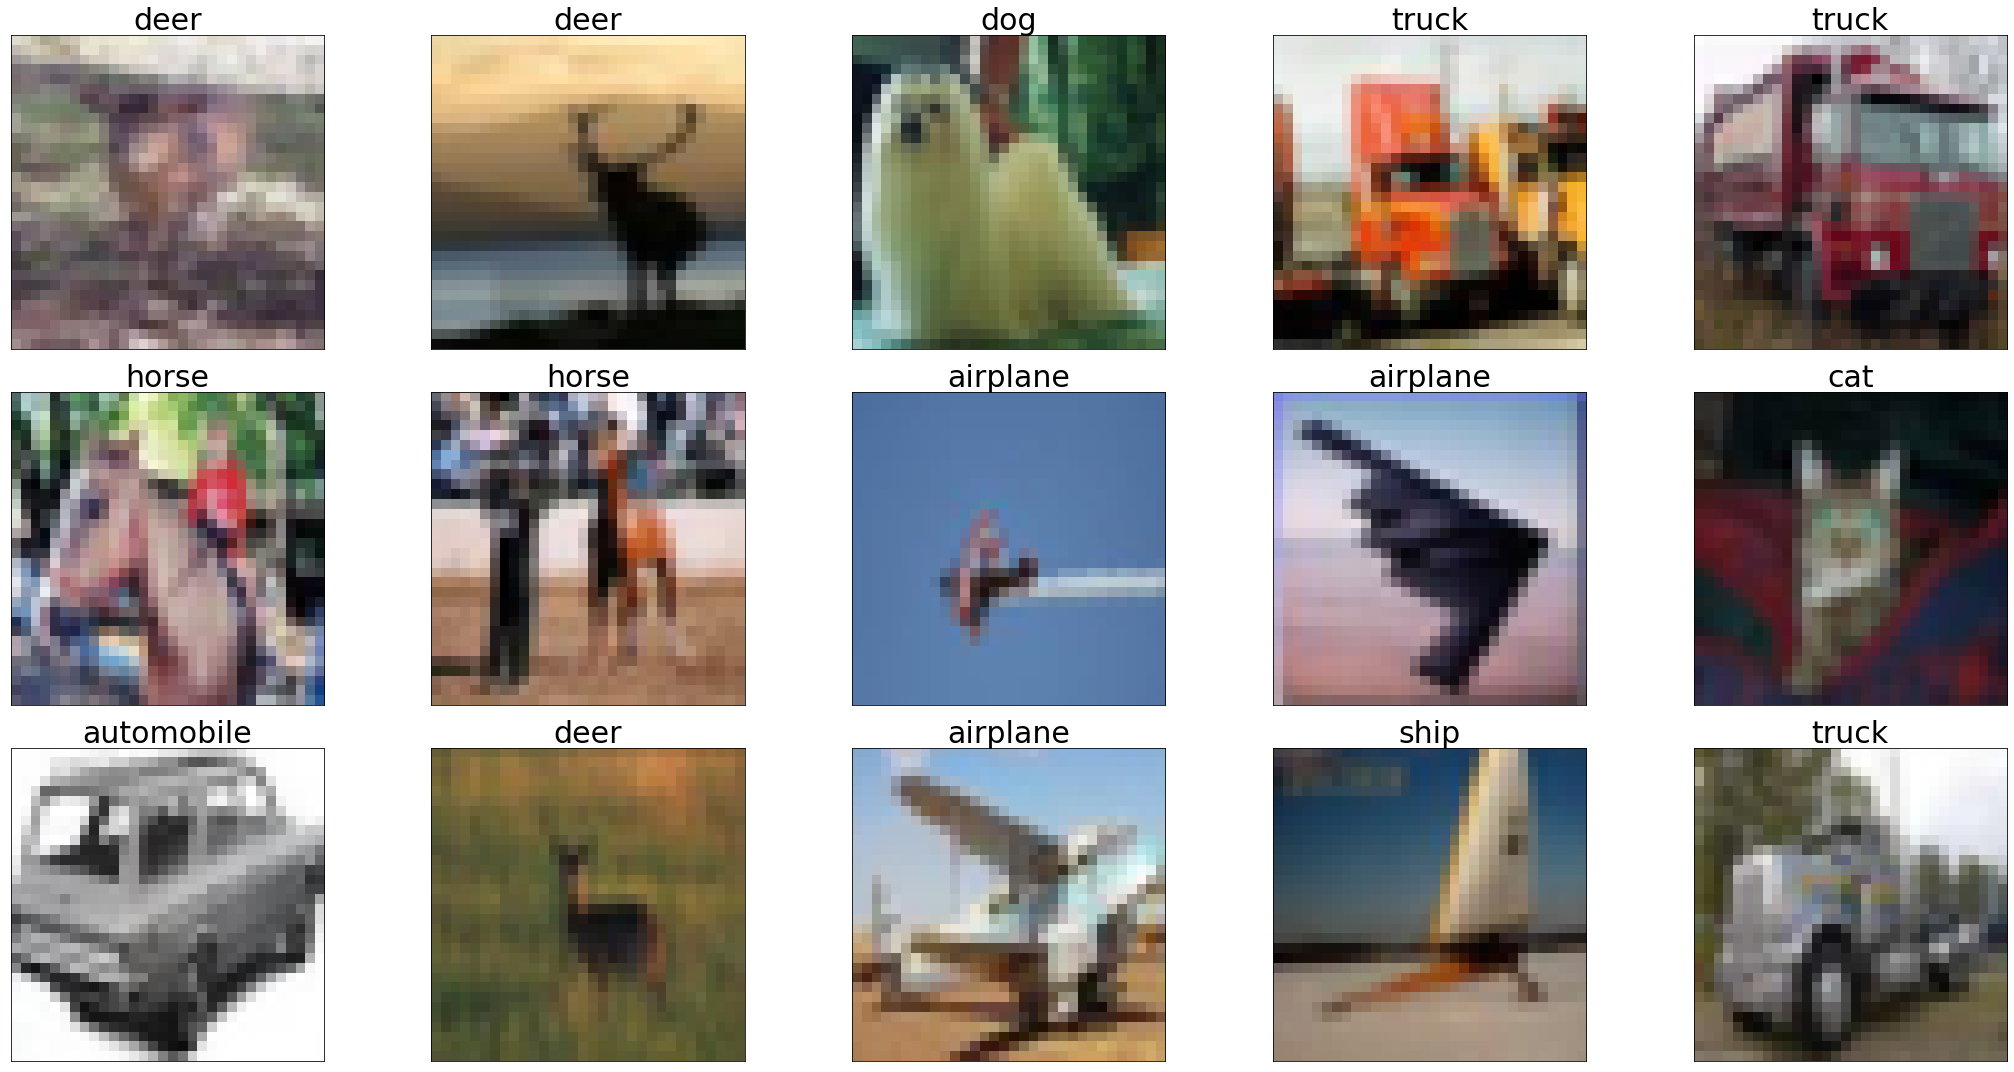

In [13]:
dataset = CIFAR10(root='.', train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# get a single batch
for x, y in loader:
    break

# preapre visualisations
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"{dataset.classes[y[ind]]}", fontdict={'size': 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

print(f"CIFAR10 classes: {dataset.classes}")

### Zadanie 1. Sieć Konwolucyjna na CIFAR10 (4 pkt.)

Zadaniem jest zaimplementowanie "od zera" sieci konwolucyjnej do klasyfikacji wieloklasowej na zbiorze CIFAR10. Należy zaimplementować zarówno model jak i pętle uczenia oraz ewaluacji. Twój kod powinien raportować *loss* w trakcie trenowania, testowania oraz *accuracy* na zbiorze testowym (opcjonalnie również na treningowym). Na koniec *accuracy* powinno osiągnąć wynik powyżej 75% na zbiorze testowym. Można korzystać z dowolnych mechanizmów dostępnych w PyTorchu.

Porady do zadania:

* Zwiększenie treningowego *batch size* może przyspieszyć uczenie, ale należy pamiętać, że, tak jak każdy hiperparametr, *batch size* ma wpływ na proces uczenia.
* Przy dobieraniu architektury bądź hiperparametrów nie testować dłużej niż kilka epok (około 5), tak aby mieć szybki feedback. Dopiero po dobraniu powyższych rzeczy puścić dłuższe uczenie. Warto przy okazji wizualizować krzywe uczenia (funkcji kosztu) aby zwrócić uwagę na to kiedy koszt zaczyna się "wypłaszczać" i czy model przypadkowo nie overfituje (patrząc na wartości kosztu na zbiorze testowym)
* Dodatkowe (nadobowiązkowe) rzeczy do poprawienia wyniku: LR Schedule, Early Stopping.

In [14]:
# tutaj zdefiniuj swój model, nie zapomnij podziedziczyć po torch.nn.Module
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  layers = [32, 32, 'M',  64, 64, 'M', 128, 128, 'M']
  
  def __init__(self):
      super(Net, self).__init__()
      self.features = self._make_layers(Net.layers)
      self.classifier = nn.Linear(2048, 10)

  def forward(self, x):
      x = self.features(x)
      x = x.view(x.size(0), -1)
      x = F.dropout(x, p=0.5, training=self.training)
      x = self.classifier(x)
      return x

  @staticmethod
  def _make_layers(cfg):
      layers = []
      in_channels = 3
      for x in cfg:
          if x == 'M':
              layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
          elif x == 'D':
              layers += [F.dropout()]
          else:
              layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                          nn.BatchNorm2d(x),
                          nn.ReLU(inplace=True)]
              in_channels = x
      layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
      return nn.Sequential(*layers)

In [15]:
# tutaj uzupełnij ładowanie danych treningowych i testowych
transforms = Compose([
  ToTensor(),
  Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=transforms)

test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform=transforms)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
# tutaj zaimplementuj pętle uczenia ze wszystkimi potrzebnymi hiperparametrami
from tqdm.notebook import tqdm
cuda = torch.cuda.is_available();

def set_lr(optimizer, lr):
    for group in optimizer.param_groups:
        group['lr'] = lr


def lr_schedule(epoch, decay_epoch, decay_epoch_step, decay_rate, learning_rate):
  frac = (epoch - decay_epoch) // decay_epoch_step
  decay_factor = decay_rate ** frac
  current_lr = learning_rate * decay_factor
  set_lr(optimizer, current_lr)


net = Net()
if cuda:
  net.cuda()

learning_rate = 0.001
momentum = 0.9
epochs = 100

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

for epoch in range(epochs):
  net.train()
  running_loss = 0
  correct = 0
  total = 0

  if epoch > 75:
    lr_schedule(epoch, 75, 5, .5, learning_rate)

  for i, (inputs, labels) in enumerate(tqdm(train_loader), 0):
    if cuda:
      inputs, labels = inputs.cuda(), labels.cuda()
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += predicted.eq(labels.data).cpu().sum()

    running_loss += loss.item()
    if i % 100 == 99:    # print every 100 mini-batches
      print('[%d, %5d] loss: %.3f | acc: %.2f%%' % 
            (epoch + 1, i + 1, running_loss / 99, 100. * correct / total))
      running_loss = 0.0

[1,   100] loss: 2.010 | acc: 30.02%
[1,   200] loss: 1.588 | acc: 36.94%
[1,   300] loss: 1.501 | acc: 40.02%
[1,   400] loss: 1.379 | acc: 42.73%
[1,   500] loss: 1.322 | acc: 44.78%
[1,   600] loss: 1.242 | acc: 46.61%
[1,   700] loss: 1.194 | acc: 48.25%



[2,   100] loss: 1.103 | acc: 61.11%
[2,   200] loss: 1.079 | acc: 61.70%
[2,   300] loss: 1.059 | acc: 62.30%
[2,   400] loss: 1.019 | acc: 62.77%
[2,   500] loss: 0.996 | acc: 63.25%
[2,   600] loss: 0.990 | acc: 63.57%
[2,   700] loss: 0.970 | acc: 63.90%



[3,   100] loss: 0.875 | acc: 69.48%
[3,   200] loss: 0.874 | acc: 69.32%
[3,   300] loss: 0.870 | acc: 69.43%
[3,   400] loss: 0.858 | acc: 69.53%
[3,   500] loss: 0.897 | acc: 69.25%
[3,   600] loss: 0.871 | acc: 69.41%
[3,   700] loss: 0.862 | acc: 69.50%



[4,   100] loss: 0.804 | acc: 72.03%
[4,   200] loss: 0.793 | acc: 72.05%
[4,   300] loss: 0.781 | acc: 72.11%
[4,   400] loss: 0.765 | acc: 72.41%
[4,   500] loss: 0.790 | acc: 72.55%
[4,   600] loss: 0.782 | acc: 72.54%
[4,   700] loss: 0.737 | acc: 72.83%



[5,   100] loss: 0.702 | acc: 75.11%
[5,   200] loss: 0.708 | acc: 75.05%
[5,   300] loss: 0.704 | acc: 75.23%
[5,   400] loss: 0.702 | acc: 75.38%
[5,   500] loss: 0.725 | acc: 75.38%
[5,   600] loss: 0.717 | acc: 75.30%
[5,   700] loss: 0.682 | acc: 75.50%



[6,   100] loss: 0.670 | acc: 76.50%
[6,   200] loss: 0.638 | acc: 76.87%
[6,   300] loss: 0.645 | acc: 77.07%
[6,   400] loss: 0.665 | acc: 77.23%
[6,   500] loss: 0.649 | acc: 77.20%
[6,   600] loss: 0.654 | acc: 77.22%
[6,   700] loss: 0.629 | acc: 77.37%



[7,   100] loss: 0.592 | acc: 79.61%
[7,   200] loss: 0.576 | acc: 79.80%
[7,   300] loss: 0.604 | acc: 79.32%
[7,   400] loss: 0.611 | acc: 79.29%
[7,   500] loss: 0.614 | acc: 79.05%
[7,   600] loss: 0.612 | acc: 78.98%
[7,   700] loss: 0.595 | acc: 79.00%



[8,   100] loss: 0.576 | acc: 79.66%
[8,   200] loss: 0.532 | acc: 80.20%
[8,   300] loss: 0.535 | acc: 80.57%
[8,   400] loss: 0.570 | acc: 80.47%
[8,   500] loss: 0.562 | acc: 80.43%
[8,   600] loss: 0.562 | acc: 80.35%
[8,   700] loss: 0.556 | acc: 80.40%



[9,   100] loss: 0.519 | acc: 81.72%
[9,   200] loss: 0.513 | acc: 81.95%
[9,   300] loss: 0.505 | acc: 82.11%
[9,   400] loss: 0.536 | acc: 82.01%
[9,   500] loss: 0.534 | acc: 81.91%
[9,   600] loss: 0.534 | acc: 81.82%
[9,   700] loss: 0.513 | acc: 81.85%



[10,   100] loss: 0.490 | acc: 83.34%
[10,   200] loss: 0.476 | acc: 83.64%
[10,   300] loss: 0.492 | acc: 83.28%
[10,   400] loss: 0.482 | acc: 83.24%
[10,   500] loss: 0.492 | acc: 83.22%
[10,   600] loss: 0.500 | acc: 83.08%
[10,   700] loss: 0.490 | acc: 83.10%



[11,   100] loss: 0.484 | acc: 82.44%
[11,   200] loss: 0.437 | acc: 83.72%
[11,   300] loss: 0.447 | acc: 84.04%
[11,   400] loss: 0.448 | acc: 84.21%
[11,   500] loss: 0.446 | acc: 84.28%
[11,   600] loss: 0.455 | acc: 84.20%
[11,   700] loss: 0.485 | acc: 84.04%



[12,   100] loss: 0.420 | acc: 85.16%
[12,   200] loss: 0.405 | acc: 85.55%
[12,   300] loss: 0.429 | acc: 85.40%
[12,   400] loss: 0.428 | acc: 85.38%
[12,   500] loss: 0.406 | acc: 85.41%
[12,   600] loss: 0.443 | acc: 85.24%
[12,   700] loss: 0.436 | acc: 85.16%



[13,   100] loss: 0.393 | acc: 86.11%
[13,   200] loss: 0.392 | acc: 86.19%
[13,   300] loss: 0.386 | acc: 86.21%
[13,   400] loss: 0.422 | acc: 86.02%
[13,   500] loss: 0.402 | acc: 86.04%
[13,   600] loss: 0.395 | acc: 86.12%
[13,   700] loss: 0.407 | acc: 86.09%



[14,   100] loss: 0.374 | acc: 87.05%
[14,   200] loss: 0.382 | acc: 86.90%
[14,   300] loss: 0.383 | acc: 86.82%
[14,   400] loss: 0.392 | acc: 86.69%
[14,   500] loss: 0.363 | acc: 86.75%
[14,   600] loss: 0.395 | acc: 86.63%
[14,   700] loss: 0.382 | acc: 86.64%



[15,   100] loss: 0.336 | acc: 88.34%
[15,   200] loss: 0.338 | acc: 88.06%
[15,   300] loss: 0.342 | acc: 87.94%
[15,   400] loss: 0.374 | acc: 87.69%
[15,   500] loss: 0.344 | acc: 87.78%
[15,   600] loss: 0.370 | acc: 87.68%
[15,   700] loss: 0.381 | acc: 87.50%



[16,   100] loss: 0.310 | acc: 89.11%
[16,   200] loss: 0.324 | acc: 88.77%
[16,   300] loss: 0.332 | acc: 88.61%
[16,   400] loss: 0.341 | acc: 88.56%
[16,   500] loss: 0.351 | acc: 88.41%
[16,   600] loss: 0.349 | acc: 88.25%
[16,   700] loss: 0.362 | acc: 88.18%



[17,   100] loss: 0.279 | acc: 90.36%
[17,   200] loss: 0.277 | acc: 90.27%
[17,   300] loss: 0.316 | acc: 89.95%
[17,   400] loss: 0.331 | acc: 89.57%
[17,   500] loss: 0.305 | acc: 89.47%
[17,   600] loss: 0.329 | acc: 89.34%
[17,   700] loss: 0.322 | acc: 89.22%



[18,   100] loss: 0.281 | acc: 90.05%
[18,   200] loss: 0.278 | acc: 90.24%
[18,   300] loss: 0.290 | acc: 90.07%
[18,   400] loss: 0.295 | acc: 90.00%
[18,   500] loss: 0.297 | acc: 89.91%
[18,   600] loss: 0.333 | acc: 89.59%
[18,   700] loss: 0.311 | acc: 89.52%



[19,   100] loss: 0.272 | acc: 90.59%
[19,   200] loss: 0.261 | acc: 90.83%
[19,   300] loss: 0.272 | acc: 90.69%
[19,   400] loss: 0.270 | acc: 90.52%
[19,   500] loss: 0.296 | acc: 90.35%
[19,   600] loss: 0.291 | acc: 90.23%
[19,   700] loss: 0.263 | acc: 90.33%



[20,   100] loss: 0.234 | acc: 92.38%
[20,   200] loss: 0.243 | acc: 91.66%
[20,   300] loss: 0.260 | acc: 91.48%
[20,   400] loss: 0.266 | acc: 91.28%
[20,   500] loss: 0.263 | acc: 91.07%
[20,   600] loss: 0.274 | acc: 90.96%
[20,   700] loss: 0.279 | acc: 90.88%



[21,   100] loss: 0.221 | acc: 92.61%
[21,   200] loss: 0.240 | acc: 92.05%
[21,   300] loss: 0.238 | acc: 91.89%
[21,   400] loss: 0.242 | acc: 91.78%
[21,   500] loss: 0.243 | acc: 91.63%
[21,   600] loss: 0.247 | acc: 91.56%
[21,   700] loss: 0.278 | acc: 91.31%



[22,   100] loss: 0.225 | acc: 91.98%
[22,   200] loss: 0.222 | acc: 92.20%
[22,   300] loss: 0.231 | acc: 91.96%
[22,   400] loss: 0.225 | acc: 91.94%
[22,   500] loss: 0.247 | acc: 91.83%
[22,   600] loss: 0.236 | acc: 91.78%
[22,   700] loss: 0.257 | acc: 91.59%



[23,   100] loss: 0.215 | acc: 92.95%
[23,   200] loss: 0.195 | acc: 92.94%
[23,   300] loss: 0.211 | acc: 92.72%
[23,   400] loss: 0.213 | acc: 92.70%
[23,   500] loss: 0.237 | acc: 92.54%
[23,   600] loss: 0.222 | acc: 92.43%
[23,   700] loss: 0.249 | acc: 92.23%



[24,   100] loss: 0.198 | acc: 92.84%
[24,   200] loss: 0.188 | acc: 93.16%
[24,   300] loss: 0.191 | acc: 93.13%
[24,   400] loss: 0.213 | acc: 93.02%
[24,   500] loss: 0.205 | acc: 92.95%
[24,   600] loss: 0.226 | acc: 92.80%
[24,   700] loss: 0.209 | acc: 92.74%



[25,   100] loss: 0.184 | acc: 93.67%
[25,   200] loss: 0.200 | acc: 93.36%
[25,   300] loss: 0.174 | acc: 93.65%
[25,   400] loss: 0.180 | acc: 93.64%
[25,   500] loss: 0.203 | acc: 93.41%
[25,   600] loss: 0.205 | acc: 93.30%
[25,   700] loss: 0.200 | acc: 93.26%



[26,   100] loss: 0.181 | acc: 93.69%
[26,   200] loss: 0.175 | acc: 93.69%
[26,   300] loss: 0.179 | acc: 93.73%
[26,   400] loss: 0.185 | acc: 93.63%
[26,   500] loss: 0.184 | acc: 93.58%
[26,   600] loss: 0.192 | acc: 93.45%
[26,   700] loss: 0.204 | acc: 93.37%



[27,   100] loss: 0.157 | acc: 94.61%
[27,   200] loss: 0.174 | acc: 94.23%
[27,   300] loss: 0.173 | acc: 94.17%
[27,   400] loss: 0.192 | acc: 93.98%
[27,   500] loss: 0.176 | acc: 93.92%
[27,   600] loss: 0.178 | acc: 93.91%
[27,   700] loss: 0.195 | acc: 93.77%



[28,   100] loss: 0.163 | acc: 94.05%
[28,   200] loss: 0.152 | acc: 94.36%
[28,   300] loss: 0.154 | acc: 94.44%
[28,   400] loss: 0.149 | acc: 94.51%
[28,   500] loss: 0.175 | acc: 94.35%
[28,   600] loss: 0.172 | acc: 94.27%
[28,   700] loss: 0.176 | acc: 94.20%



[29,   100] loss: 0.141 | acc: 95.23%
[29,   200] loss: 0.134 | acc: 95.20%
[29,   300] loss: 0.147 | acc: 95.06%
[29,   400] loss: 0.159 | acc: 94.97%
[29,   500] loss: 0.168 | acc: 94.78%
[29,   600] loss: 0.164 | acc: 94.63%
[29,   700] loss: 0.181 | acc: 94.44%



[30,   100] loss: 0.144 | acc: 94.88%
[30,   200] loss: 0.142 | acc: 95.06%
[30,   300] loss: 0.150 | acc: 94.91%
[30,   400] loss: 0.155 | acc: 94.85%
[30,   500] loss: 0.149 | acc: 94.80%
[30,   600] loss: 0.148 | acc: 94.78%
[30,   700] loss: 0.164 | acc: 94.69%



[31,   100] loss: 0.125 | acc: 95.59%
[31,   200] loss: 0.132 | acc: 95.49%
[31,   300] loss: 0.147 | acc: 95.26%
[31,   400] loss: 0.135 | acc: 95.25%
[31,   500] loss: 0.148 | acc: 95.11%
[31,   600] loss: 0.151 | acc: 95.05%
[31,   700] loss: 0.147 | acc: 94.99%



[32,   100] loss: 0.112 | acc: 96.12%
[32,   200] loss: 0.122 | acc: 95.98%
[32,   300] loss: 0.133 | acc: 95.79%
[32,   400] loss: 0.133 | acc: 95.69%
[32,   500] loss: 0.132 | acc: 95.65%
[32,   600] loss: 0.139 | acc: 95.52%
[32,   700] loss: 0.139 | acc: 95.46%



[33,   100] loss: 0.110 | acc: 96.34%
[33,   200] loss: 0.103 | acc: 96.31%
[33,   300] loss: 0.118 | acc: 96.12%
[33,   400] loss: 0.122 | acc: 95.99%
[33,   500] loss: 0.122 | acc: 95.93%
[33,   600] loss: 0.128 | acc: 95.87%
[33,   700] loss: 0.141 | acc: 95.78%



[34,   100] loss: 0.110 | acc: 96.05%
[34,   200] loss: 0.113 | acc: 96.09%
[34,   300] loss: 0.118 | acc: 95.98%
[34,   400] loss: 0.111 | acc: 96.02%
[34,   500] loss: 0.133 | acc: 95.88%
[34,   600] loss: 0.123 | acc: 95.87%
[34,   700] loss: 0.124 | acc: 95.79%



[35,   100] loss: 0.117 | acc: 95.81%
[35,   200] loss: 0.112 | acc: 96.02%
[35,   300] loss: 0.100 | acc: 96.19%
[35,   400] loss: 0.115 | acc: 96.09%
[35,   500] loss: 0.110 | acc: 96.12%
[35,   600] loss: 0.117 | acc: 96.17%
[35,   700] loss: 0.120 | acc: 96.10%



[36,   100] loss: 0.110 | acc: 96.23%
[36,   200] loss: 0.100 | acc: 96.42%
[36,   300] loss: 0.112 | acc: 96.33%
[36,   400] loss: 0.096 | acc: 96.39%
[36,   500] loss: 0.106 | acc: 96.34%
[36,   600] loss: 0.107 | acc: 96.33%
[36,   700] loss: 0.107 | acc: 96.35%



[37,   100] loss: 0.104 | acc: 96.19%
[37,   200] loss: 0.105 | acc: 96.23%
[37,   300] loss: 0.093 | acc: 96.27%
[37,   400] loss: 0.100 | acc: 96.38%
[37,   500] loss: 0.100 | acc: 96.42%
[37,   600] loss: 0.109 | acc: 96.41%
[37,   700] loss: 0.117 | acc: 96.35%



[38,   100] loss: 0.104 | acc: 96.31%
[38,   200] loss: 0.089 | acc: 96.46%
[38,   300] loss: 0.093 | acc: 96.57%
[38,   400] loss: 0.093 | acc: 96.67%
[38,   500] loss: 0.099 | acc: 96.68%
[38,   600] loss: 0.107 | acc: 96.61%
[38,   700] loss: 0.112 | acc: 96.53%



[39,   100] loss: 0.098 | acc: 96.69%
[39,   200] loss: 0.086 | acc: 96.89%
[39,   300] loss: 0.087 | acc: 97.01%
[39,   400] loss: 0.098 | acc: 96.91%
[39,   500] loss: 0.100 | acc: 96.83%
[39,   600] loss: 0.110 | acc: 96.71%
[39,   700] loss: 0.094 | acc: 96.73%



[40,   100] loss: 0.085 | acc: 97.06%
[40,   200] loss: 0.080 | acc: 97.12%
[40,   300] loss: 0.088 | acc: 97.13%
[40,   400] loss: 0.088 | acc: 97.11%
[40,   500] loss: 0.100 | acc: 97.00%
[40,   600] loss: 0.098 | acc: 96.93%
[40,   700] loss: 0.095 | acc: 96.90%



[41,   100] loss: 0.080 | acc: 97.45%
[41,   200] loss: 0.073 | acc: 97.49%
[41,   300] loss: 0.082 | acc: 97.34%
[41,   400] loss: 0.080 | acc: 97.29%
[41,   500] loss: 0.087 | acc: 97.17%
[41,   600] loss: 0.087 | acc: 97.16%
[41,   700] loss: 0.097 | acc: 97.08%



[42,   100] loss: 0.083 | acc: 97.00%
[42,   200] loss: 0.087 | acc: 97.09%
[42,   300] loss: 0.081 | acc: 97.12%
[42,   400] loss: 0.090 | acc: 96.99%
[42,   500] loss: 0.078 | acc: 97.05%
[42,   600] loss: 0.077 | acc: 97.09%
[42,   700] loss: 0.086 | acc: 97.06%



[43,   100] loss: 0.083 | acc: 97.20%
[43,   200] loss: 0.076 | acc: 97.23%
[43,   300] loss: 0.083 | acc: 97.16%
[43,   400] loss: 0.075 | acc: 97.18%
[43,   500] loss: 0.083 | acc: 97.15%
[43,   600] loss: 0.089 | acc: 97.10%
[43,   700] loss: 0.075 | acc: 97.14%



[44,   100] loss: 0.069 | acc: 97.62%
[44,   200] loss: 0.065 | acc: 97.81%
[44,   300] loss: 0.067 | acc: 97.82%
[44,   400] loss: 0.071 | acc: 97.77%
[44,   500] loss: 0.076 | acc: 97.68%
[44,   600] loss: 0.079 | acc: 97.63%
[44,   700] loss: 0.079 | acc: 97.58%



[45,   100] loss: 0.067 | acc: 97.66%
[45,   200] loss: 0.061 | acc: 97.83%
[45,   300] loss: 0.080 | acc: 97.64%
[45,   400] loss: 0.076 | acc: 97.55%
[45,   500] loss: 0.079 | acc: 97.50%
[45,   600] loss: 0.078 | acc: 97.46%
[45,   700] loss: 0.083 | acc: 97.44%



[46,   100] loss: 0.069 | acc: 97.67%
[46,   200] loss: 0.066 | acc: 97.68%
[46,   300] loss: 0.069 | acc: 97.69%
[46,   400] loss: 0.075 | acc: 97.62%
[46,   500] loss: 0.070 | acc: 97.64%
[46,   600] loss: 0.061 | acc: 97.71%
[46,   700] loss: 0.070 | acc: 97.73%



[47,   100] loss: 0.065 | acc: 97.81%
[47,   200] loss: 0.061 | acc: 97.84%
[47,   300] loss: 0.061 | acc: 97.92%
[47,   400] loss: 0.073 | acc: 97.84%
[47,   500] loss: 0.072 | acc: 97.77%
[47,   600] loss: 0.066 | acc: 97.75%
[47,   700] loss: 0.081 | acc: 97.66%



[48,   100] loss: 0.067 | acc: 97.61%
[48,   200] loss: 0.067 | acc: 97.70%
[48,   300] loss: 0.079 | acc: 97.51%
[48,   400] loss: 0.072 | acc: 97.52%
[48,   500] loss: 0.081 | acc: 97.43%
[48,   600] loss: 0.069 | acc: 97.47%
[48,   700] loss: 0.074 | acc: 97.46%



[49,   100] loss: 0.065 | acc: 97.88%
[49,   200] loss: 0.057 | acc: 97.90%
[49,   300] loss: 0.056 | acc: 98.00%
[49,   400] loss: 0.058 | acc: 98.03%
[49,   500] loss: 0.063 | acc: 98.00%
[49,   600] loss: 0.069 | acc: 97.95%
[49,   700] loss: 0.066 | acc: 97.91%



[50,   100] loss: 0.051 | acc: 98.45%
[50,   200] loss: 0.055 | acc: 98.32%
[50,   300] loss: 0.063 | acc: 98.15%
[50,   400] loss: 0.064 | acc: 98.03%
[50,   500] loss: 0.061 | acc: 98.00%
[50,   600] loss: 0.057 | acc: 98.00%
[50,   700] loss: 0.063 | acc: 97.98%



[51,   100] loss: 0.049 | acc: 98.36%
[51,   200] loss: 0.062 | acc: 98.12%
[51,   300] loss: 0.060 | acc: 98.03%
[51,   400] loss: 0.058 | acc: 98.06%
[51,   500] loss: 0.056 | acc: 98.07%
[51,   600] loss: 0.060 | acc: 98.05%
[51,   700] loss: 0.056 | acc: 98.08%



[52,   100] loss: 0.057 | acc: 98.27%
[52,   200] loss: 0.050 | acc: 98.35%
[52,   300] loss: 0.048 | acc: 98.39%
[52,   400] loss: 0.055 | acc: 98.35%
[52,   500] loss: 0.059 | acc: 98.31%
[52,   600] loss: 0.060 | acc: 98.27%
[52,   700] loss: 0.064 | acc: 98.21%



[53,   100] loss: 0.051 | acc: 98.23%
[53,   200] loss: 0.046 | acc: 98.36%
[53,   300] loss: 0.059 | acc: 98.24%
[53,   400] loss: 0.057 | acc: 98.19%
[53,   500] loss: 0.054 | acc: 98.22%
[53,   600] loss: 0.062 | acc: 98.17%
[53,   700] loss: 0.068 | acc: 98.13%



[54,   100] loss: 0.047 | acc: 98.44%
[54,   200] loss: 0.052 | acc: 98.34%
[54,   300] loss: 0.050 | acc: 98.34%
[54,   400] loss: 0.064 | acc: 98.24%
[54,   500] loss: 0.055 | acc: 98.23%
[54,   600] loss: 0.056 | acc: 98.21%
[54,   700] loss: 0.049 | acc: 98.23%



[55,   100] loss: 0.066 | acc: 97.72%
[55,   200] loss: 0.053 | acc: 97.93%
[55,   300] loss: 0.060 | acc: 97.97%
[55,   400] loss: 0.050 | acc: 98.02%
[55,   500] loss: 0.051 | acc: 98.09%
[55,   600] loss: 0.055 | acc: 98.07%
[55,   700] loss: 0.061 | acc: 98.05%



[56,   100] loss: 0.052 | acc: 98.14%
[56,   200] loss: 0.056 | acc: 98.07%
[56,   300] loss: 0.055 | acc: 98.10%
[56,   400] loss: 0.048 | acc: 98.18%
[56,   500] loss: 0.047 | acc: 98.24%
[56,   600] loss: 0.051 | acc: 98.26%
[56,   700] loss: 0.048 | acc: 98.27%



[57,   100] loss: 0.051 | acc: 98.31%
[57,   200] loss: 0.051 | acc: 98.33%
[57,   300] loss: 0.048 | acc: 98.33%
[57,   400] loss: 0.050 | acc: 98.38%
[57,   500] loss: 0.048 | acc: 98.39%
[57,   600] loss: 0.054 | acc: 98.34%
[57,   700] loss: 0.053 | acc: 98.33%



[58,   100] loss: 0.047 | acc: 98.53%
[58,   200] loss: 0.046 | acc: 98.51%
[58,   300] loss: 0.044 | acc: 98.53%
[58,   400] loss: 0.046 | acc: 98.49%
[58,   500] loss: 0.042 | acc: 98.50%
[58,   600] loss: 0.050 | acc: 98.47%
[58,   700] loss: 0.045 | acc: 98.48%



[59,   100] loss: 0.047 | acc: 98.12%
[59,   200] loss: 0.042 | acc: 98.35%
[59,   300] loss: 0.037 | acc: 98.50%
[59,   400] loss: 0.049 | acc: 98.45%
[59,   500] loss: 0.039 | acc: 98.47%
[59,   600] loss: 0.049 | acc: 98.45%
[59,   700] loss: 0.053 | acc: 98.41%



[60,   100] loss: 0.043 | acc: 98.44%
[60,   200] loss: 0.039 | acc: 98.55%
[60,   300] loss: 0.042 | acc: 98.56%
[60,   400] loss: 0.039 | acc: 98.58%
[60,   500] loss: 0.040 | acc: 98.59%
[60,   600] loss: 0.047 | acc: 98.59%
[60,   700] loss: 0.044 | acc: 98.57%



[61,   100] loss: 0.041 | acc: 98.88%
[61,   200] loss: 0.036 | acc: 98.86%
[61,   300] loss: 0.040 | acc: 98.82%
[61,   400] loss: 0.043 | acc: 98.75%
[61,   500] loss: 0.042 | acc: 98.73%
[61,   600] loss: 0.044 | acc: 98.70%
[61,   700] loss: 0.044 | acc: 98.68%



[62,   100] loss: 0.034 | acc: 98.98%
[62,   200] loss: 0.042 | acc: 98.85%
[62,   300] loss: 0.038 | acc: 98.85%
[62,   400] loss: 0.040 | acc: 98.78%
[62,   500] loss: 0.039 | acc: 98.75%
[62,   600] loss: 0.043 | acc: 98.72%
[62,   700] loss: 0.049 | acc: 98.65%



[63,   100] loss: 0.040 | acc: 98.62%
[63,   200] loss: 0.041 | acc: 98.54%
[63,   300] loss: 0.037 | acc: 98.66%
[63,   400] loss: 0.052 | acc: 98.53%
[63,   500] loss: 0.048 | acc: 98.47%
[63,   600] loss: 0.041 | acc: 98.52%
[63,   700] loss: 0.036 | acc: 98.55%



[64,   100] loss: 0.033 | acc: 98.94%
[64,   200] loss: 0.034 | acc: 98.96%
[64,   300] loss: 0.044 | acc: 98.82%
[64,   400] loss: 0.044 | acc: 98.77%
[64,   500] loss: 0.040 | acc: 98.73%
[64,   600] loss: 0.039 | acc: 98.72%
[64,   700] loss: 0.047 | acc: 98.68%



[65,   100] loss: 0.038 | acc: 98.72%
[65,   200] loss: 0.031 | acc: 98.84%
[65,   300] loss: 0.033 | acc: 98.85%
[65,   400] loss: 0.041 | acc: 98.80%
[65,   500] loss: 0.038 | acc: 98.77%
[65,   600] loss: 0.032 | acc: 98.80%
[65,   700] loss: 0.039 | acc: 98.76%



[66,   100] loss: 0.041 | acc: 98.62%
[66,   200] loss: 0.030 | acc: 98.88%
[66,   300] loss: 0.032 | acc: 98.92%
[66,   400] loss: 0.030 | acc: 98.93%
[66,   500] loss: 0.046 | acc: 98.79%
[66,   600] loss: 0.041 | acc: 98.74%
[66,   700] loss: 0.044 | acc: 98.70%



[67,   100] loss: 0.039 | acc: 98.80%
[67,   200] loss: 0.030 | acc: 98.92%
[67,   300] loss: 0.040 | acc: 98.85%
[67,   400] loss: 0.032 | acc: 98.89%
[67,   500] loss: 0.043 | acc: 98.81%
[67,   600] loss: 0.035 | acc: 98.80%
[67,   700] loss: 0.037 | acc: 98.79%



[68,   100] loss: 0.030 | acc: 99.02%
[68,   200] loss: 0.028 | acc: 99.12%
[68,   300] loss: 0.030 | acc: 99.10%
[68,   400] loss: 0.037 | acc: 98.99%
[68,   500] loss: 0.040 | acc: 98.93%
[68,   600] loss: 0.038 | acc: 98.91%
[68,   700] loss: 0.044 | acc: 98.83%



[69,   100] loss: 0.031 | acc: 98.81%
[69,   200] loss: 0.033 | acc: 98.78%
[69,   300] loss: 0.036 | acc: 98.78%
[69,   400] loss: 0.032 | acc: 98.82%
[69,   500] loss: 0.033 | acc: 98.83%
[69,   600] loss: 0.040 | acc: 98.80%
[69,   700] loss: 0.037 | acc: 98.79%



[70,   100] loss: 0.039 | acc: 98.77%
[70,   200] loss: 0.028 | acc: 98.95%
[70,   300] loss: 0.031 | acc: 98.98%
[70,   400] loss: 0.030 | acc: 98.98%
[70,   500] loss: 0.031 | acc: 98.99%
[70,   600] loss: 0.038 | acc: 98.95%
[70,   700] loss: 0.034 | acc: 98.96%



[71,   100] loss: 0.032 | acc: 98.94%
[71,   200] loss: 0.031 | acc: 98.98%
[71,   300] loss: 0.033 | acc: 98.92%
[71,   400] loss: 0.039 | acc: 98.91%
[71,   500] loss: 0.039 | acc: 98.89%
[71,   600] loss: 0.037 | acc: 98.84%
[71,   700] loss: 0.029 | acc: 98.89%



[72,   100] loss: 0.036 | acc: 98.77%
[72,   200] loss: 0.035 | acc: 98.80%
[72,   300] loss: 0.028 | acc: 98.90%
[72,   400] loss: 0.038 | acc: 98.82%
[72,   500] loss: 0.028 | acc: 98.88%
[72,   600] loss: 0.031 | acc: 98.91%
[72,   700] loss: 0.037 | acc: 98.88%



[73,   100] loss: 0.028 | acc: 99.11%
[73,   200] loss: 0.029 | acc: 99.14%
[73,   300] loss: 0.033 | acc: 99.05%
[73,   400] loss: 0.027 | acc: 99.06%
[73,   500] loss: 0.037 | acc: 99.00%
[73,   600] loss: 0.029 | acc: 99.01%
[73,   700] loss: 0.033 | acc: 98.97%



[74,   100] loss: 0.033 | acc: 98.95%
[74,   200] loss: 0.030 | acc: 98.99%
[74,   300] loss: 0.030 | acc: 99.00%
[74,   400] loss: 0.033 | acc: 98.97%
[74,   500] loss: 0.031 | acc: 98.95%
[74,   600] loss: 0.028 | acc: 98.96%
[74,   700] loss: 0.026 | acc: 99.00%



[75,   100] loss: 0.027 | acc: 99.08%
[75,   200] loss: 0.026 | acc: 99.11%
[75,   300] loss: 0.031 | acc: 99.10%
[75,   400] loss: 0.030 | acc: 99.07%
[75,   500] loss: 0.024 | acc: 99.09%
[75,   600] loss: 0.024 | acc: 99.14%
[75,   700] loss: 0.022 | acc: 99.16%



[76,   100] loss: 0.030 | acc: 99.05%
[76,   200] loss: 0.033 | acc: 99.00%
[76,   300] loss: 0.031 | acc: 98.96%
[76,   400] loss: 0.033 | acc: 98.93%
[76,   500] loss: 0.031 | acc: 98.94%
[76,   600] loss: 0.030 | acc: 98.95%
[76,   700] loss: 0.033 | acc: 98.96%



[77,   100] loss: 0.026 | acc: 99.19%
[77,   200] loss: 0.026 | acc: 99.12%
[77,   300] loss: 0.031 | acc: 99.08%
[77,   400] loss: 0.025 | acc: 99.12%
[77,   500] loss: 0.020 | acc: 99.20%
[77,   600] loss: 0.025 | acc: 99.19%
[77,   700] loss: 0.040 | acc: 99.09%



[78,   100] loss: 0.023 | acc: 99.25%
[78,   200] loss: 0.023 | acc: 99.26%
[78,   300] loss: 0.026 | acc: 99.21%
[78,   400] loss: 0.025 | acc: 99.19%
[78,   500] loss: 0.032 | acc: 99.16%
[78,   600] loss: 0.030 | acc: 99.14%
[78,   700] loss: 0.031 | acc: 99.11%



[79,   100] loss: 0.029 | acc: 99.11%
[79,   200] loss: 0.023 | acc: 99.21%
[79,   300] loss: 0.026 | acc: 99.20%
[79,   400] loss: 0.026 | acc: 99.17%
[79,   500] loss: 0.025 | acc: 99.15%
[79,   600] loss: 0.028 | acc: 99.15%
[79,   700] loss: 0.025 | acc: 99.18%



[80,   100] loss: 0.026 | acc: 99.03%
[80,   200] loss: 0.026 | acc: 99.12%
[80,   300] loss: 0.033 | acc: 99.02%
[80,   400] loss: 0.030 | acc: 99.00%
[80,   500] loss: 0.026 | acc: 99.00%
[80,   600] loss: 0.035 | acc: 98.98%
[80,   700] loss: 0.032 | acc: 98.96%



[81,   100] loss: 0.023 | acc: 99.28%
[81,   200] loss: 0.017 | acc: 99.37%
[81,   300] loss: 0.017 | acc: 99.42%
[81,   400] loss: 0.014 | acc: 99.47%
[81,   500] loss: 0.015 | acc: 99.49%
[81,   600] loss: 0.014 | acc: 99.51%
[81,   700] loss: 0.018 | acc: 99.50%



[82,   100] loss: 0.012 | acc: 99.69%
[82,   200] loss: 0.015 | acc: 99.62%
[82,   300] loss: 0.013 | acc: 99.61%
[82,   400] loss: 0.014 | acc: 99.60%
[82,   500] loss: 0.012 | acc: 99.62%
[82,   600] loss: 0.011 | acc: 99.63%
[82,   700] loss: 0.012 | acc: 99.64%



[83,   100] loss: 0.011 | acc: 99.75%
[83,   200] loss: 0.013 | acc: 99.70%
[83,   300] loss: 0.011 | acc: 99.70%
[83,   400] loss: 0.012 | acc: 99.68%
[83,   500] loss: 0.011 | acc: 99.69%
[83,   600] loss: 0.012 | acc: 99.69%
[83,   700] loss: 0.010 | acc: 99.70%



[84,   100] loss: 0.012 | acc: 99.61%
[84,   200] loss: 0.011 | acc: 99.66%
[84,   300] loss: 0.012 | acc: 99.64%
[84,   400] loss: 0.013 | acc: 99.64%
[84,   500] loss: 0.012 | acc: 99.63%
[84,   600] loss: 0.010 | acc: 99.65%
[84,   700] loss: 0.009 | acc: 99.68%



[85,   100] loss: 0.011 | acc: 99.75%
[85,   200] loss: 0.011 | acc: 99.69%
[85,   300] loss: 0.013 | acc: 99.66%
[85,   400] loss: 0.010 | acc: 99.69%
[85,   500] loss: 0.010 | acc: 99.71%
[85,   600] loss: 0.013 | acc: 99.70%
[85,   700] loss: 0.008 | acc: 99.72%



[86,   100] loss: 0.010 | acc: 99.67%
[86,   200] loss: 0.009 | acc: 99.75%
[86,   300] loss: 0.009 | acc: 99.73%
[86,   400] loss: 0.008 | acc: 99.76%
[86,   500] loss: 0.008 | acc: 99.78%
[86,   600] loss: 0.008 | acc: 99.78%
[86,   700] loss: 0.010 | acc: 99.78%



[87,   100] loss: 0.007 | acc: 99.84%
[87,   200] loss: 0.008 | acc: 99.84%
[87,   300] loss: 0.008 | acc: 99.81%
[87,   400] loss: 0.008 | acc: 99.81%
[87,   500] loss: 0.007 | acc: 99.81%
[87,   600] loss: 0.008 | acc: 99.81%
[87,   700] loss: 0.008 | acc: 99.81%



[88,   100] loss: 0.008 | acc: 99.75%
[88,   200] loss: 0.009 | acc: 99.77%
[88,   300] loss: 0.007 | acc: 99.80%
[88,   400] loss: 0.007 | acc: 99.83%
[88,   500] loss: 0.008 | acc: 99.82%
[88,   600] loss: 0.008 | acc: 99.82%
[88,   700] loss: 0.009 | acc: 99.82%



[89,   100] loss: 0.007 | acc: 99.84%
[89,   200] loss: 0.006 | acc: 99.87%
[89,   300] loss: 0.008 | acc: 99.86%
[89,   400] loss: 0.009 | acc: 99.83%
[89,   500] loss: 0.007 | acc: 99.84%
[89,   600] loss: 0.008 | acc: 99.82%
[89,   700] loss: 0.005 | acc: 99.84%



[90,   100] loss: 0.007 | acc: 99.83%
[90,   200] loss: 0.007 | acc: 99.83%
[90,   300] loss: 0.006 | acc: 99.82%
[90,   400] loss: 0.007 | acc: 99.82%
[90,   500] loss: 0.008 | acc: 99.83%
[90,   600] loss: 0.006 | acc: 99.84%
[90,   700] loss: 0.007 | acc: 99.84%



[91,   100] loss: 0.006 | acc: 99.92%
[91,   200] loss: 0.007 | acc: 99.90%
[91,   300] loss: 0.006 | acc: 99.89%
[91,   400] loss: 0.006 | acc: 99.89%
[91,   500] loss: 0.006 | acc: 99.88%
[91,   600] loss: 0.007 | acc: 99.88%
[91,   700] loss: 0.006 | acc: 99.88%



[92,   100] loss: 0.005 | acc: 99.91%
[92,   200] loss: 0.006 | acc: 99.90%
[92,   300] loss: 0.006 | acc: 99.90%
[92,   400] loss: 0.006 | acc: 99.90%
[92,   500] loss: 0.007 | acc: 99.88%
[92,   600] loss: 0.008 | acc: 99.87%
[92,   700] loss: 0.007 | acc: 99.87%



[93,   100] loss: 0.006 | acc: 99.88%
[93,   200] loss: 0.006 | acc: 99.87%
[93,   300] loss: 0.006 | acc: 99.88%
[93,   400] loss: 0.006 | acc: 99.88%
[93,   500] loss: 0.007 | acc: 99.87%
[93,   600] loss: 0.005 | acc: 99.88%
[93,   700] loss: 0.008 | acc: 99.87%



[94,   100] loss: 0.007 | acc: 99.84%
[94,   200] loss: 0.006 | acc: 99.83%
[94,   300] loss: 0.007 | acc: 99.83%
[94,   400] loss: 0.006 | acc: 99.84%
[94,   500] loss: 0.006 | acc: 99.84%
[94,   600] loss: 0.006 | acc: 99.85%
[94,   700] loss: 0.006 | acc: 99.85%



[95,   100] loss: 0.006 | acc: 99.84%
[95,   200] loss: 0.005 | acc: 99.89%
[95,   300] loss: 0.007 | acc: 99.89%
[95,   400] loss: 0.006 | acc: 99.89%
[95,   500] loss: 0.005 | acc: 99.89%
[95,   600] loss: 0.006 | acc: 99.89%
[95,   700] loss: 0.006 | acc: 99.89%



[96,   100] loss: 0.006 | acc: 99.84%
[96,   200] loss: 0.007 | acc: 99.82%
[96,   300] loss: 0.006 | acc: 99.83%
[96,   400] loss: 0.006 | acc: 99.85%
[96,   500] loss: 0.006 | acc: 99.85%
[96,   600] loss: 0.006 | acc: 99.85%
[96,   700] loss: 0.007 | acc: 99.85%



[97,   100] loss: 0.004 | acc: 99.94%
[97,   200] loss: 0.006 | acc: 99.89%
[97,   300] loss: 0.005 | acc: 99.88%
[97,   400] loss: 0.005 | acc: 99.88%
[97,   500] loss: 0.007 | acc: 99.87%
[97,   600] loss: 0.006 | acc: 99.88%
[97,   700] loss: 0.004 | acc: 99.89%



[98,   100] loss: 0.007 | acc: 99.80%
[98,   200] loss: 0.006 | acc: 99.80%
[98,   300] loss: 0.006 | acc: 99.82%
[98,   400] loss: 0.006 | acc: 99.84%
[98,   500] loss: 0.006 | acc: 99.83%
[98,   600] loss: 0.006 | acc: 99.84%
[98,   700] loss: 0.007 | acc: 99.83%



[99,   100] loss: 0.006 | acc: 99.84%
[99,   200] loss: 0.007 | acc: 99.83%
[99,   300] loss: 0.005 | acc: 99.84%
[99,   400] loss: 0.005 | acc: 99.86%
[99,   500] loss: 0.006 | acc: 99.86%
[99,   600] loss: 0.007 | acc: 99.86%
[99,   700] loss: 0.006 | acc: 99.87%



[100,   100] loss: 0.005 | acc: 99.91%
[100,   200] loss: 0.006 | acc: 99.90%
[100,   300] loss: 0.005 | acc: 99.91%
[100,   400] loss: 0.006 | acc: 99.89%
[100,   500] loss: 0.004 | acc: 99.90%
[100,   600] loss: 0.006 | acc: 99.90%
[100,   700] loss: 0.007 | acc: 99.90%



In [17]:
# test
correct = 0
total = 0
with torch.no_grad():
    for (inputs, labels) in test_loader:
        if cuda:
          inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        print('[%d] loss: %.3f | acc: %.2f%%' % 
              (i + 1, loss.item(), 100. * correct / total))

acc_no_aug = 100 * correct / total
print('Accuracy of the network on the test images: %.2f %%' % (acc_no_aug))

[782] loss: 0.996 | acc: 82.30%
[782] loss: 0.952 | acc: 82.64%
Accuracy of the network on the test images: 82.64 %


## Augmentacje

Pakiet `torchvision` implementuje wiele różnych transformacji do danych, część z nich jest użyteczna do tzw. augmentacji danych. Augmentacja danych to mechanizm "sztucznego" zwiększania datasetu treningowego poprzez dodawanie do niego zmodyfikowanych kopii danych, które już w nim istnieją. Augmentacja jest szczególnie użyteczna kiedy nasz dataset ma małą liczbę przykładów do uczenia skomplikowanych sieci neuronowych. 

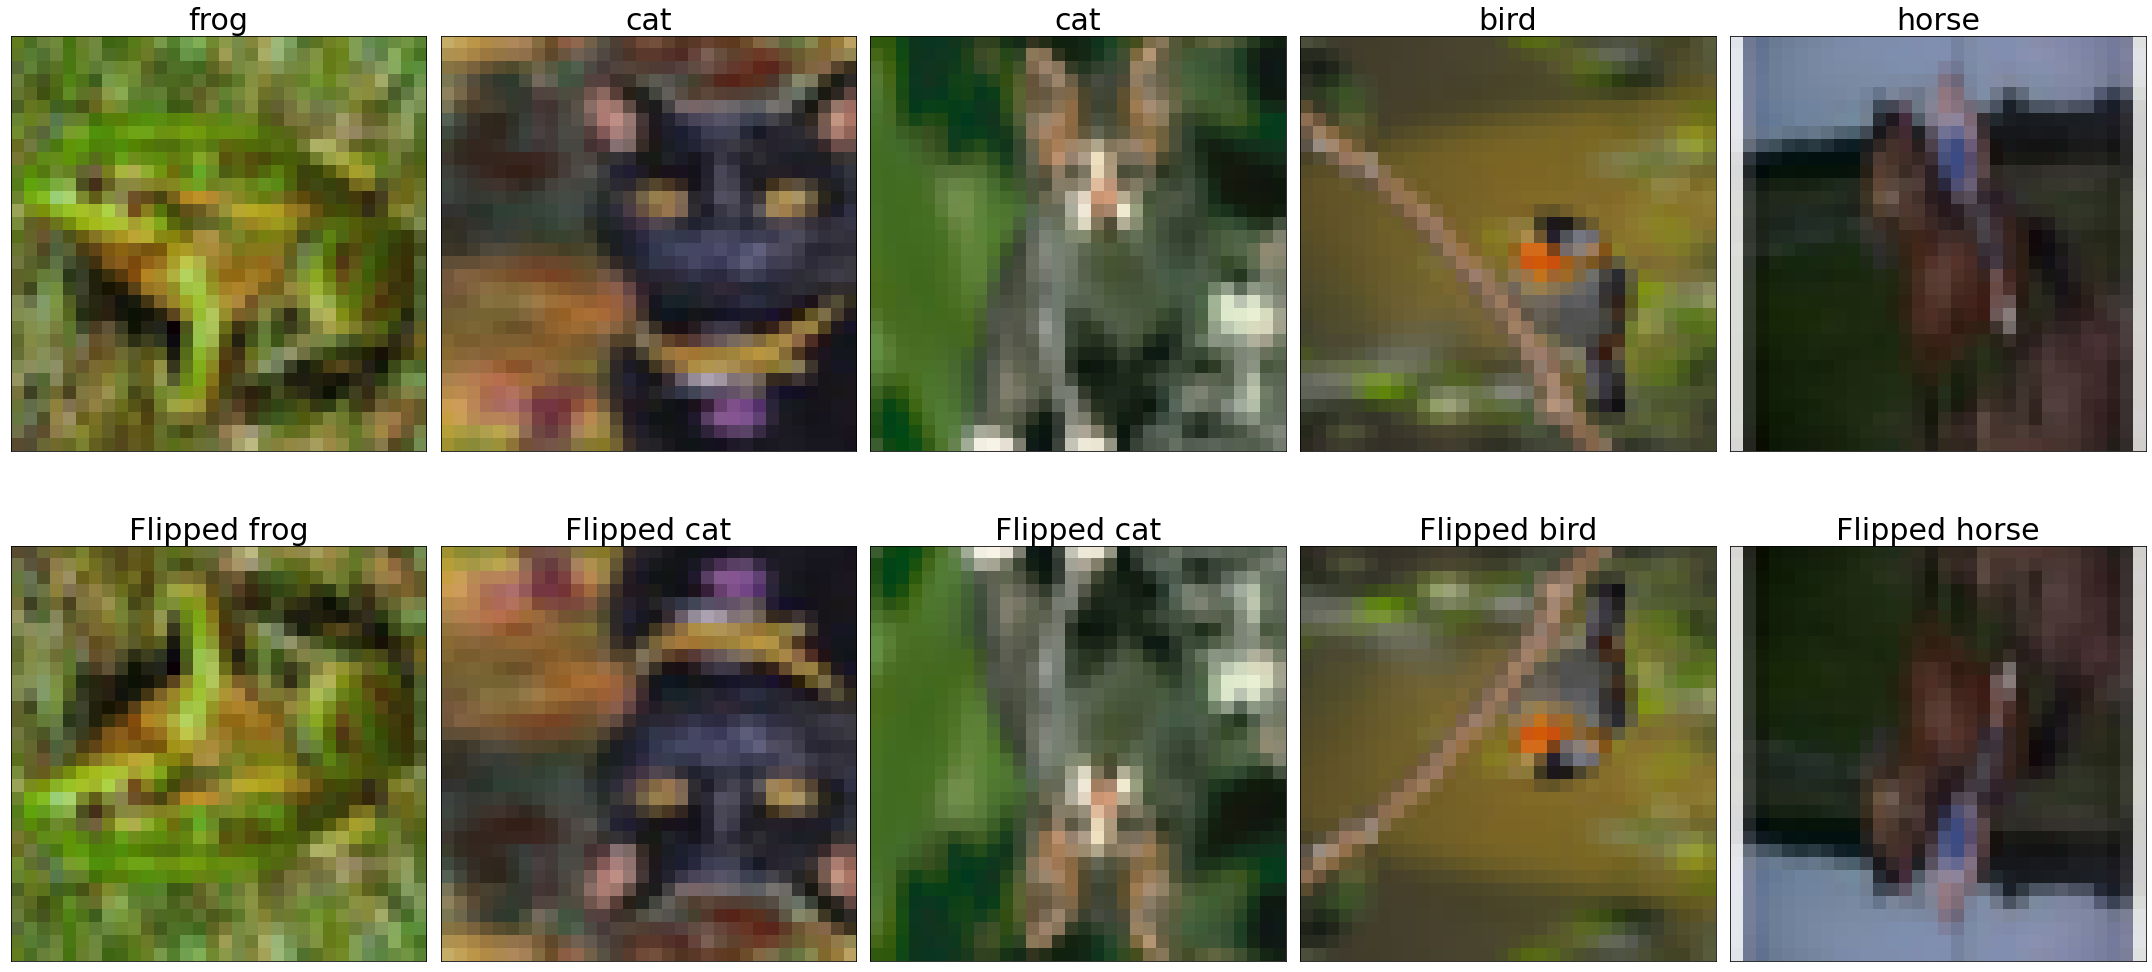

In [18]:
from torchvision.transforms import RandomVerticalFlip

# load test set
dataset = CIFAR10(root='.', train=True, transform=ToTensor())
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# prepare a random flip
flip = RandomVerticalFlip(p=1) 

# load some data
for x, y in loader:
    break
    

# visualise the flipping
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 15))

for img, label, ax in zip(x, y, axes[0]):
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(f"{dataset.classes[label]}", fontdict={'size': 30})
    ax.set_xticks([])
    ax.set_yticks([])
    
for img, label, ax in zip(x, y, axes[1]):
    ax.imshow(np.transpose(flip(img), (1, 2, 0)))
    ax.set_title(f"Flipped {dataset.classes[label]}", fontdict={'size': 30})
    ax.set_xticks([])
    ax.set_yticks([])


fig.tight_layout()

### Zadanie 2. Augmentacja danych (1 pkt.)

Używając funkcjonalności dostępnych w [`torchvision.transforms`](https://pytorch.org/docs/stable/torchvision/transforms.html) dodaj augmentacje danych do datasetu treningowego, zobacz o ile poprawia to wynik twojego modelu z poprzedniego zadania. W razie wątpliwości najlepiej przeszukać internet w poszukiwaniu typowych augmentacji dla CIFAR10.

In [19]:
# tutaj dodaj wybrane augumentcje danych treningowych i załaduj testowe
transforms_train = Compose([
  RandomHorizontalFlip(),
  RandomAffine((-10, 10), (.1, .1)),
  ToTensor(),
  Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=transforms_train)

test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform=transforms_train)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
# tutaj powtórz pętle uczenia z poprzedniego zadania
net_aug = Net()
if cuda:
  net_aug.cuda()
learning_rate = 0.001
momentum = 0.9
epochs = 100

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_aug.parameters(), lr=learning_rate, momentum=momentum)

for epoch in range(epochs):
  net_aug.train()
  running_loss = 0
  correct = 0
  total = 0

  if epoch > 75:
    lr_schedule(epoch, 75, 5, .5, learning_rate)

  for i, (inputs, labels) in enumerate(tqdm(train_loader), 0):
    if cuda:
      inputs, labels = inputs.cuda(), labels.cuda()
    optimizer.zero_grad()
    outputs = net_aug(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += predicted.eq(labels.data).cpu().sum()

    running_loss += loss.item()
    if i % 100 == 99:    # print every 100 mini-batches
      print('[%d, %5d] loss: %.3f | acc: %.2f%%' % 
            (epoch + 1, i + 1, running_loss / 99, 100. * correct / total))
      running_loss = 0.0

[1,   100] loss: 2.063 | acc: 26.66%
[1,   200] loss: 1.700 | acc: 32.62%
[1,   300] loss: 1.628 | acc: 35.51%
[1,   400] loss: 1.543 | acc: 37.72%
[1,   500] loss: 1.491 | acc: 39.53%
[1,   600] loss: 1.446 | acc: 41.01%
[1,   700] loss: 1.419 | acc: 42.15%



[2,   100] loss: 1.320 | acc: 52.77%
[2,   200] loss: 1.270 | acc: 53.73%
[2,   300] loss: 1.273 | acc: 54.12%
[2,   400] loss: 1.251 | acc: 54.55%
[2,   500] loss: 1.243 | acc: 54.80%
[2,   600] loss: 1.237 | acc: 55.10%
[2,   700] loss: 1.211 | acc: 55.48%



[3,   100] loss: 1.153 | acc: 59.78%


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f98a0687d30>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f98a84b4cc0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

[3,   200] loss: 1.099 | acc: 60.61%
[3,   300] loss: 1.107 | acc: 60.46%
[3,   400] loss: 1.084 | acc: 60.86%
[3,   500] loss: 1.053 | acc: 61.49%
[3,   600] loss: 1.084 | acc: 61.53%
[3,   700] loss: 1.038 | acc: 61.83%



Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f98a0687d30>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f98a0687d30>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object

[4,   100] loss: 1.009 | acc: 64.69%
[4,   200] loss: 1.024 | acc: 64.77%
[4,   300] loss: 0.999 | acc: 64.94%
[4,   400] loss: 1.001 | acc: 65.00%
[4,   500] loss: 0.972 | acc: 65.24%
[4,   600] loss: 0.981 | acc: 65.33%
[4,   700] loss: 0.964 | acc: 65.42%



[5,   100] loss: 0.936 | acc: 67.19%
[5,   200] loss: 0.946 | acc: 67.09%
[5,   300] loss: 0.934 | acc: 67.11%
[5,   400] loss: 0.924 | acc: 67.25%
[5,   500] loss: 0.902 | acc: 67.54%
[5,   600] loss: 0.927 | acc: 67.44%
[5,   700] loss: 0.903 | acc: 67.66%



[6,   100] loss: 0.886 | acc: 69.12%
[6,   200] loss: 0.904 | acc: 68.98%
[6,   300] loss: 0.844 | acc: 69.47%
[6,   400] loss: 0.867 | acc: 69.62%
[6,   500] loss: 0.889 | acc: 69.51%
[6,   600] loss: 0.849 | acc: 69.68%
[6,   700] loss: 0.868 | acc: 69.72%



[7,   100] loss: 0.836 | acc: 70.77%
[7,   200] loss: 0.852 | acc: 70.57%
[7,   300] loss: 0.823 | acc: 70.80%
[7,   400] loss: 0.837 | acc: 70.70%
[7,   500] loss: 0.826 | acc: 70.78%
[7,   600] loss: 0.830 | acc: 70.89%
[7,   700] loss: 0.808 | acc: 71.01%



[8,   100] loss: 0.797 | acc: 72.44%
[8,   200] loss: 0.788 | acc: 72.30%
[8,   300] loss: 0.792 | acc: 72.47%
[8,   400] loss: 0.788 | acc: 72.54%
[8,   500] loss: 0.808 | acc: 72.39%
[8,   600] loss: 0.762 | acc: 72.62%
[8,   700] loss: 0.766 | acc: 72.78%



[9,   100] loss: 0.751 | acc: 73.81%
[9,   200] loss: 0.755 | acc: 73.53%
[9,   300] loss: 0.763 | acc: 73.70%
[9,   400] loss: 0.753 | acc: 73.79%
[9,   500] loss: 0.766 | acc: 73.57%
[9,   600] loss: 0.780 | acc: 73.45%
[9,   700] loss: 0.763 | acc: 73.41%



[10,   100] loss: 0.726 | acc: 75.11%
[10,   200] loss: 0.694 | acc: 75.31%
[10,   300] loss: 0.742 | acc: 75.07%
[10,   400] loss: 0.745 | acc: 75.00%
[10,   500] loss: 0.754 | acc: 74.78%
[10,   600] loss: 0.717 | acc: 74.81%
[10,   700] loss: 0.746 | acc: 74.72%



[11,   100] loss: 0.719 | acc: 74.92%
[11,   200] loss: 0.702 | acc: 75.45%
[11,   300] loss: 0.708 | acc: 75.42%
[11,   400] loss: 0.717 | acc: 75.33%
[11,   500] loss: 0.687 | acc: 75.46%
[11,   600] loss: 0.709 | acc: 75.46%
[11,   700] loss: 0.704 | acc: 75.53%



[12,   100] loss: 0.697 | acc: 75.50%
[12,   200] loss: 0.685 | acc: 76.00%
[12,   300] loss: 0.660 | acc: 76.37%
[12,   400] loss: 0.705 | acc: 76.14%
[12,   500] loss: 0.685 | acc: 76.17%
[12,   600] loss: 0.695 | acc: 76.17%
[12,   700] loss: 0.685 | acc: 76.14%



[13,   100] loss: 0.658 | acc: 77.08%
[13,   200] loss: 0.674 | acc: 76.98%
[13,   300] loss: 0.679 | acc: 76.82%
[13,   400] loss: 0.676 | acc: 76.79%
[13,   500] loss: 0.674 | acc: 76.62%
[13,   600] loss: 0.675 | acc: 76.61%
[13,   700] loss: 0.678 | acc: 76.59%



[14,   100] loss: 0.642 | acc: 78.22%
[14,   200] loss: 0.672 | acc: 77.45%
[14,   300] loss: 0.659 | acc: 77.32%
[14,   400] loss: 0.646 | acc: 77.44%
[14,   500] loss: 0.622 | acc: 77.72%
[14,   600] loss: 0.671 | acc: 77.52%
[14,   700] loss: 0.641 | acc: 77.59%



[15,   100] loss: 0.625 | acc: 78.28%
[15,   200] loss: 0.651 | acc: 77.98%
[15,   300] loss: 0.638 | acc: 78.09%
[15,   400] loss: 0.627 | acc: 78.16%
[15,   500] loss: 0.648 | acc: 78.09%
[15,   600] loss: 0.632 | acc: 78.02%
[15,   700] loss: 0.658 | acc: 77.91%



[16,   100] loss: 0.604 | acc: 78.95%
[16,   200] loss: 0.637 | acc: 78.45%
[16,   300] loss: 0.631 | acc: 78.34%
[16,   400] loss: 0.619 | acc: 78.41%
[16,   500] loss: 0.638 | acc: 78.23%
[16,   600] loss: 0.610 | acc: 78.39%
[16,   700] loss: 0.616 | acc: 78.37%



[17,   100] loss: 0.593 | acc: 78.95%
[17,   200] loss: 0.616 | acc: 78.73%
[17,   300] loss: 0.634 | acc: 78.55%
[17,   400] loss: 0.617 | acc: 78.49%
[17,   500] loss: 0.596 | acc: 78.80%
[17,   600] loss: 0.610 | acc: 78.85%
[17,   700] loss: 0.595 | acc: 78.94%



[18,   100] loss: 0.600 | acc: 79.27%
[18,   200] loss: 0.620 | acc: 78.97%
[18,   300] loss: 0.593 | acc: 79.28%
[18,   400] loss: 0.593 | acc: 79.21%
[18,   500] loss: 0.589 | acc: 79.35%
[18,   600] loss: 0.602 | acc: 79.34%
[18,   700] loss: 0.578 | acc: 79.42%



[19,   100] loss: 0.583 | acc: 79.59%
[19,   200] loss: 0.570 | acc: 80.00%
[19,   300] loss: 0.579 | acc: 80.06%
[19,   400] loss: 0.609 | acc: 79.96%
[19,   500] loss: 0.569 | acc: 80.04%
[19,   600] loss: 0.594 | acc: 79.87%
[19,   700] loss: 0.583 | acc: 79.77%



[20,   100] loss: 0.574 | acc: 80.56%
[20,   200] loss: 0.591 | acc: 80.34%
[20,   300] loss: 0.558 | acc: 80.28%
[20,   400] loss: 0.561 | acc: 80.39%
[20,   500] loss: 0.569 | acc: 80.33%
[20,   600] loss: 0.583 | acc: 80.23%
[20,   700] loss: 0.562 | acc: 80.29%



[21,   100] loss: 0.546 | acc: 81.06%
[21,   200] loss: 0.556 | acc: 80.82%
[21,   300] loss: 0.545 | acc: 80.88%
[21,   400] loss: 0.559 | acc: 80.89%
[21,   500] loss: 0.567 | acc: 80.82%
[21,   600] loss: 0.559 | acc: 80.79%
[21,   700] loss: 0.586 | acc: 80.65%



[22,   100] loss: 0.554 | acc: 81.05%
[22,   200] loss: 0.529 | acc: 81.42%
[22,   300] loss: 0.551 | acc: 81.38%
[22,   400] loss: 0.577 | acc: 81.09%
[22,   500] loss: 0.554 | acc: 80.97%
[22,   600] loss: 0.560 | acc: 80.87%
[22,   700] loss: 0.554 | acc: 80.86%



[23,   100] loss: 0.541 | acc: 81.03%
[23,   200] loss: 0.547 | acc: 81.16%
[23,   300] loss: 0.544 | acc: 81.14%
[23,   400] loss: 0.534 | acc: 81.18%
[23,   500] loss: 0.526 | acc: 81.27%
[23,   600] loss: 0.546 | acc: 81.26%
[23,   700] loss: 0.540 | acc: 81.22%



[24,   100] loss: 0.529 | acc: 81.75%
[24,   200] loss: 0.535 | acc: 81.72%
[24,   300] loss: 0.544 | acc: 81.59%
[24,   400] loss: 0.537 | acc: 81.63%
[24,   500] loss: 0.548 | acc: 81.65%
[24,   600] loss: 0.519 | acc: 81.62%
[24,   700] loss: 0.537 | acc: 81.60%



[25,   100] loss: 0.543 | acc: 81.02%
[25,   200] loss: 0.510 | acc: 81.50%
[25,   300] loss: 0.526 | acc: 81.57%
[25,   400] loss: 0.527 | acc: 81.64%
[25,   500] loss: 0.529 | acc: 81.69%
[25,   600] loss: 0.514 | acc: 81.79%
[25,   700] loss: 0.534 | acc: 81.73%



[26,   100] loss: 0.498 | acc: 82.91%
[26,   200] loss: 0.527 | acc: 82.38%
[26,   300] loss: 0.525 | acc: 82.11%
[26,   400] loss: 0.496 | acc: 82.37%
[26,   500] loss: 0.522 | acc: 82.25%
[26,   600] loss: 0.515 | acc: 82.17%
[26,   700] loss: 0.520 | acc: 82.19%



[27,   100] loss: 0.520 | acc: 82.19%
[27,   200] loss: 0.498 | acc: 82.52%
[27,   300] loss: 0.502 | acc: 82.82%
[27,   400] loss: 0.501 | acc: 82.77%
[27,   500] loss: 0.532 | acc: 82.60%
[27,   600] loss: 0.521 | acc: 82.45%
[27,   700] loss: 0.507 | acc: 82.51%



[28,   100] loss: 0.479 | acc: 82.98%
[28,   200] loss: 0.494 | acc: 83.11%
[28,   300] loss: 0.496 | acc: 83.07%
[28,   400] loss: 0.502 | acc: 82.95%
[28,   500] loss: 0.491 | acc: 82.96%
[28,   600] loss: 0.503 | acc: 82.92%
[28,   700] loss: 0.499 | acc: 82.90%



[29,   100] loss: 0.469 | acc: 83.72%
[29,   200] loss: 0.473 | acc: 83.51%
[29,   300] loss: 0.497 | acc: 83.44%
[29,   400] loss: 0.508 | acc: 83.21%
[29,   500] loss: 0.484 | acc: 83.15%
[29,   600] loss: 0.490 | acc: 83.10%
[29,   700] loss: 0.511 | acc: 83.01%



[30,   100] loss: 0.504 | acc: 82.56%
[30,   200] loss: 0.466 | acc: 83.28%
[30,   300] loss: 0.479 | acc: 83.22%
[30,   400] loss: 0.467 | acc: 83.34%
[30,   500] loss: 0.514 | acc: 83.08%
[30,   600] loss: 0.470 | acc: 83.21%
[30,   700] loss: 0.483 | acc: 83.24%



[31,   100] loss: 0.474 | acc: 83.59%
[31,   200] loss: 0.500 | acc: 83.00%
[31,   300] loss: 0.457 | acc: 83.33%
[31,   400] loss: 0.478 | acc: 83.38%
[31,   500] loss: 0.482 | acc: 83.36%
[31,   600] loss: 0.477 | acc: 83.40%
[31,   700] loss: 0.468 | acc: 83.52%



[32,   100] loss: 0.472 | acc: 83.75%
[32,   200] loss: 0.490 | acc: 83.45%
[32,   300] loss: 0.479 | acc: 83.43%
[32,   400] loss: 0.465 | acc: 83.46%
[32,   500] loss: 0.456 | acc: 83.71%
[32,   600] loss: 0.481 | acc: 83.58%
[32,   700] loss: 0.492 | acc: 83.58%



[33,   100] loss: 0.479 | acc: 83.62%
[33,   200] loss: 0.472 | acc: 83.66%
[33,   300] loss: 0.454 | acc: 83.82%
[33,   400] loss: 0.474 | acc: 83.70%
[33,   500] loss: 0.473 | acc: 83.71%
[33,   600] loss: 0.454 | acc: 83.86%
[33,   700] loss: 0.466 | acc: 83.87%



[34,   100] loss: 0.444 | acc: 84.61%
[34,   200] loss: 0.452 | acc: 84.51%
[34,   300] loss: 0.474 | acc: 84.20%
[34,   400] loss: 0.472 | acc: 84.09%
[34,   500] loss: 0.471 | acc: 84.08%
[34,   600] loss: 0.452 | acc: 84.09%
[34,   700] loss: 0.476 | acc: 83.98%



[35,   100] loss: 0.445 | acc: 84.53%
[35,   200] loss: 0.460 | acc: 84.33%
[35,   300] loss: 0.457 | acc: 84.27%
[35,   400] loss: 0.464 | acc: 84.19%
[35,   500] loss: 0.445 | acc: 84.37%
[35,   600] loss: 0.459 | acc: 84.31%
[35,   700] loss: 0.450 | acc: 84.37%



[36,   100] loss: 0.455 | acc: 84.06%
[36,   200] loss: 0.440 | acc: 84.26%
[36,   300] loss: 0.449 | acc: 84.40%
[36,   400] loss: 0.448 | acc: 84.33%
[36,   500] loss: 0.445 | acc: 84.32%
[36,   600] loss: 0.446 | acc: 84.31%
[36,   700] loss: 0.459 | acc: 84.34%



[37,   100] loss: 0.444 | acc: 85.28%
[37,   200] loss: 0.432 | acc: 85.24%
[37,   300] loss: 0.449 | acc: 85.07%
[37,   400] loss: 0.444 | acc: 85.02%
[37,   500] loss: 0.445 | acc: 85.05%
[37,   600] loss: 0.426 | acc: 85.05%
[37,   700] loss: 0.454 | acc: 84.95%



[38,   100] loss: 0.431 | acc: 84.72%
[38,   200] loss: 0.424 | acc: 85.01%
[38,   300] loss: 0.436 | acc: 84.96%
[38,   400] loss: 0.462 | acc: 84.87%
[38,   500] loss: 0.438 | acc: 84.94%
[38,   600] loss: 0.439 | acc: 84.98%
[38,   700] loss: 0.448 | acc: 84.90%



[39,   100] loss: 0.422 | acc: 85.52%
[39,   200] loss: 0.428 | acc: 85.41%
[39,   300] loss: 0.439 | acc: 85.14%
[39,   400] loss: 0.429 | acc: 85.10%
[39,   500] loss: 0.441 | acc: 85.07%
[39,   600] loss: 0.431 | acc: 85.05%
[39,   700] loss: 0.448 | acc: 85.05%



[40,   100] loss: 0.437 | acc: 84.42%
[40,   200] loss: 0.429 | acc: 84.83%
[40,   300] loss: 0.411 | acc: 85.21%
[40,   400] loss: 0.447 | acc: 85.18%
[40,   500] loss: 0.443 | acc: 85.08%
[40,   600] loss: 0.425 | acc: 85.15%
[40,   700] loss: 0.429 | acc: 85.09%



[41,   100] loss: 0.403 | acc: 86.48%
[41,   200] loss: 0.424 | acc: 85.77%
[41,   300] loss: 0.425 | acc: 85.59%
[41,   400] loss: 0.416 | acc: 85.63%
[41,   500] loss: 0.418 | acc: 85.62%
[41,   600] loss: 0.429 | acc: 85.49%
[41,   700] loss: 0.423 | acc: 85.46%



[42,   100] loss: 0.421 | acc: 85.73%
[42,   200] loss: 0.413 | acc: 85.59%
[42,   300] loss: 0.418 | acc: 85.49%
[42,   400] loss: 0.405 | acc: 85.63%
[42,   500] loss: 0.412 | acc: 85.72%
[42,   600] loss: 0.444 | acc: 85.60%
[42,   700] loss: 0.426 | acc: 85.59%



[43,   100] loss: 0.422 | acc: 85.25%
[43,   200] loss: 0.400 | acc: 85.60%
[43,   300] loss: 0.421 | acc: 85.62%
[43,   400] loss: 0.408 | acc: 85.74%
[43,   500] loss: 0.422 | acc: 85.70%
[43,   600] loss: 0.416 | acc: 85.69%
[43,   700] loss: 0.414 | acc: 85.71%



[44,   100] loss: 0.396 | acc: 86.09%
[44,   200] loss: 0.389 | acc: 86.37%
[44,   300] loss: 0.444 | acc: 85.83%
[44,   400] loss: 0.415 | acc: 85.73%
[44,   500] loss: 0.403 | acc: 85.86%
[44,   600] loss: 0.404 | acc: 85.95%
[44,   700] loss: 0.423 | acc: 85.90%



[45,   100] loss: 0.406 | acc: 85.98%
[45,   200] loss: 0.417 | acc: 85.59%
[45,   300] loss: 0.399 | acc: 85.85%
[45,   400] loss: 0.433 | acc: 85.66%
[45,   500] loss: 0.395 | acc: 85.78%
[45,   600] loss: 0.374 | acc: 85.99%
[45,   700] loss: 0.411 | acc: 86.00%



[46,   100] loss: 0.387 | acc: 86.81%
[46,   200] loss: 0.401 | acc: 86.72%
[46,   300] loss: 0.398 | acc: 86.53%
[46,   400] loss: 0.397 | acc: 86.52%
[46,   500] loss: 0.420 | acc: 86.22%
[46,   600] loss: 0.404 | acc: 86.16%
[46,   700] loss: 0.406 | acc: 86.12%



[47,   100] loss: 0.417 | acc: 85.52%
[47,   200] loss: 0.399 | acc: 85.98%
[47,   300] loss: 0.398 | acc: 85.92%
[47,   400] loss: 0.401 | acc: 86.07%
[47,   500] loss: 0.394 | acc: 86.11%
[47,   600] loss: 0.394 | acc: 86.11%
[47,   700] loss: 0.399 | acc: 86.14%



[48,   100] loss: 0.405 | acc: 86.38%
[48,   200] loss: 0.393 | acc: 86.15%
[48,   300] loss: 0.365 | acc: 86.55%
[48,   400] loss: 0.394 | acc: 86.51%
[48,   500] loss: 0.388 | acc: 86.48%
[48,   600] loss: 0.404 | acc: 86.36%
[48,   700] loss: 0.413 | acc: 86.22%



[49,   100] loss: 0.384 | acc: 86.08%
[49,   200] loss: 0.391 | acc: 86.14%
[49,   300] loss: 0.376 | acc: 86.38%
[49,   400] loss: 0.387 | acc: 86.35%
[49,   500] loss: 0.400 | acc: 86.31%
[49,   600] loss: 0.388 | acc: 86.31%
[49,   700] loss: 0.387 | acc: 86.37%



[50,   100] loss: 0.370 | acc: 87.12%
[50,   200] loss: 0.408 | acc: 86.75%
[50,   300] loss: 0.404 | acc: 86.58%
[50,   400] loss: 0.372 | acc: 86.67%
[50,   500] loss: 0.363 | acc: 86.84%
[50,   600] loss: 0.380 | acc: 86.83%
[50,   700] loss: 0.393 | acc: 86.69%



[51,   100] loss: 0.383 | acc: 86.72%
[51,   200] loss: 0.382 | acc: 86.68%
[51,   300] loss: 0.374 | acc: 86.88%
[51,   400] loss: 0.382 | acc: 86.80%
[51,   500] loss: 0.375 | acc: 86.77%
[51,   600] loss: 0.371 | acc: 86.84%
[51,   700] loss: 0.370 | acc: 86.90%



[52,   100] loss: 0.388 | acc: 86.73%
[52,   200] loss: 0.361 | acc: 86.98%
[52,   300] loss: 0.384 | acc: 86.90%
[52,   400] loss: 0.362 | acc: 87.00%
[52,   500] loss: 0.383 | acc: 87.00%
[52,   600] loss: 0.377 | acc: 86.92%
[52,   700] loss: 0.384 | acc: 86.90%



[53,   100] loss: 0.354 | acc: 87.92%
[53,   200] loss: 0.368 | acc: 87.52%
[53,   300] loss: 0.371 | acc: 87.49%
[53,   400] loss: 0.375 | acc: 87.30%
[53,   500] loss: 0.376 | acc: 87.32%
[53,   600] loss: 0.399 | acc: 87.19%
[53,   700] loss: 0.396 | acc: 87.05%



[54,   100] loss: 0.371 | acc: 87.12%
[54,   200] loss: 0.360 | acc: 87.45%
[54,   300] loss: 0.366 | acc: 87.44%
[54,   400] loss: 0.377 | acc: 87.40%
[54,   500] loss: 0.371 | acc: 87.37%
[54,   600] loss: 0.387 | acc: 87.26%
[54,   700] loss: 0.363 | acc: 87.32%



[55,   100] loss: 0.359 | acc: 87.42%
[55,   200] loss: 0.377 | acc: 87.06%
[55,   300] loss: 0.361 | acc: 87.20%
[55,   400] loss: 0.378 | acc: 87.12%
[55,   500] loss: 0.360 | acc: 87.16%
[55,   600] loss: 0.381 | acc: 87.10%
[55,   700] loss: 0.362 | acc: 87.14%



[56,   100] loss: 0.364 | acc: 86.97%
[56,   200] loss: 0.372 | acc: 87.06%
[56,   300] loss: 0.369 | acc: 87.08%
[56,   400] loss: 0.375 | acc: 87.02%
[56,   500] loss: 0.369 | acc: 87.05%
[56,   600] loss: 0.362 | acc: 87.14%
[56,   700] loss: 0.372 | acc: 87.15%



[57,   100] loss: 0.357 | acc: 87.39%
[57,   200] loss: 0.351 | acc: 87.89%
[57,   300] loss: 0.361 | acc: 87.80%
[57,   400] loss: 0.365 | acc: 87.62%
[57,   500] loss: 0.376 | acc: 87.53%
[57,   600] loss: 0.373 | acc: 87.41%
[57,   700] loss: 0.366 | acc: 87.42%



[58,   100] loss: 0.352 | acc: 87.50%
[58,   200] loss: 0.370 | acc: 87.45%
[58,   300] loss: 0.361 | acc: 87.47%
[58,   400] loss: 0.364 | acc: 87.39%
[58,   500] loss: 0.365 | acc: 87.45%
[58,   600] loss: 0.367 | acc: 87.41%
[58,   700] loss: 0.352 | acc: 87.46%



[59,   100] loss: 0.352 | acc: 87.56%
[59,   200] loss: 0.359 | acc: 87.59%
[59,   300] loss: 0.362 | acc: 87.62%
[59,   400] loss: 0.356 | acc: 87.60%
[59,   500] loss: 0.374 | acc: 87.42%
[59,   600] loss: 0.360 | acc: 87.46%
[59,   700] loss: 0.358 | acc: 87.48%



[60,   100] loss: 0.347 | acc: 87.91%
[60,   200] loss: 0.348 | acc: 88.03%
[60,   300] loss: 0.338 | acc: 88.10%
[60,   400] loss: 0.365 | acc: 87.86%
[60,   500] loss: 0.372 | acc: 87.65%
[60,   600] loss: 0.363 | acc: 87.68%
[60,   700] loss: 0.345 | acc: 87.70%



[61,   100] loss: 0.328 | acc: 88.53%
[61,   200] loss: 0.340 | acc: 88.25%
[61,   300] loss: 0.343 | acc: 88.19%
[61,   400] loss: 0.362 | acc: 88.03%
[61,   500] loss: 0.353 | acc: 88.00%
[61,   600] loss: 0.359 | acc: 87.86%
[61,   700] loss: 0.365 | acc: 87.79%



[62,   100] loss: 0.348 | acc: 88.19%
[62,   200] loss: 0.344 | acc: 88.16%
[62,   300] loss: 0.349 | acc: 88.14%
[62,   400] loss: 0.356 | acc: 88.00%
[62,   500] loss: 0.352 | acc: 87.96%
[62,   600] loss: 0.325 | acc: 88.04%
[62,   700] loss: 0.358 | acc: 87.96%



[63,   100] loss: 0.328 | acc: 88.34%
[63,   200] loss: 0.330 | acc: 88.34%
[63,   300] loss: 0.334 | acc: 88.43%
[63,   400] loss: 0.379 | acc: 88.08%
[63,   500] loss: 0.362 | acc: 87.98%
[63,   600] loss: 0.357 | acc: 87.92%
[63,   700] loss: 0.365 | acc: 87.83%



[64,   100] loss: 0.360 | acc: 87.41%
[64,   200] loss: 0.351 | acc: 87.53%
[64,   300] loss: 0.318 | acc: 87.98%
[64,   400] loss: 0.349 | acc: 88.08%
[64,   500] loss: 0.338 | acc: 88.12%
[64,   600] loss: 0.343 | acc: 88.15%
[64,   700] loss: 0.358 | acc: 88.02%



[65,   100] loss: 0.342 | acc: 88.23%
[65,   200] loss: 0.323 | acc: 88.53%
[65,   300] loss: 0.354 | acc: 88.32%
[65,   400] loss: 0.339 | acc: 88.25%
[65,   500] loss: 0.343 | acc: 88.22%
[65,   600] loss: 0.350 | acc: 88.18%
[65,   700] loss: 0.349 | acc: 88.16%



[66,   100] loss: 0.347 | acc: 87.36%
[66,   200] loss: 0.316 | acc: 88.05%
[66,   300] loss: 0.323 | acc: 88.30%
[66,   400] loss: 0.329 | acc: 88.32%
[66,   500] loss: 0.345 | acc: 88.28%
[66,   600] loss: 0.342 | acc: 88.28%
[66,   700] loss: 0.341 | acc: 88.17%



[67,   100] loss: 0.320 | acc: 88.95%
[67,   200] loss: 0.318 | acc: 89.13%
[67,   300] loss: 0.362 | acc: 88.59%
[67,   400] loss: 0.336 | acc: 88.51%
[67,   500] loss: 0.342 | acc: 88.44%
[67,   600] loss: 0.321 | acc: 88.51%
[67,   700] loss: 0.345 | acc: 88.36%



[68,   100] loss: 0.323 | acc: 88.81%
[68,   200] loss: 0.339 | acc: 88.44%
[68,   300] loss: 0.341 | acc: 88.37%
[68,   400] loss: 0.326 | acc: 88.43%
[68,   500] loss: 0.344 | acc: 88.33%
[68,   600] loss: 0.321 | acc: 88.38%
[68,   700] loss: 0.335 | acc: 88.37%



[69,   100] loss: 0.332 | acc: 88.52%
[69,   200] loss: 0.351 | acc: 88.12%
[69,   300] loss: 0.318 | acc: 88.53%
[69,   400] loss: 0.330 | acc: 88.47%
[69,   500] loss: 0.323 | acc: 88.43%
[69,   600] loss: 0.331 | acc: 88.51%
[69,   700] loss: 0.340 | acc: 88.44%



[70,   100] loss: 0.323 | acc: 88.62%
[70,   200] loss: 0.316 | acc: 88.90%
[70,   300] loss: 0.334 | acc: 88.70%
[70,   400] loss: 0.325 | acc: 88.71%
[70,   500] loss: 0.312 | acc: 88.81%
[70,   600] loss: 0.338 | acc: 88.71%
[70,   700] loss: 0.341 | acc: 88.62%



[71,   100] loss: 0.324 | acc: 88.61%
[71,   200] loss: 0.319 | acc: 88.91%
[71,   300] loss: 0.334 | acc: 88.91%
[71,   400] loss: 0.320 | acc: 88.86%
[71,   500] loss: 0.340 | acc: 88.77%
[71,   600] loss: 0.310 | acc: 88.83%
[71,   700] loss: 0.332 | acc: 88.74%



[72,   100] loss: 0.308 | acc: 89.17%
[72,   200] loss: 0.323 | acc: 88.83%
[72,   300] loss: 0.320 | acc: 88.81%
[72,   400] loss: 0.335 | acc: 88.70%
[72,   500] loss: 0.333 | acc: 88.71%
[72,   600] loss: 0.325 | acc: 88.77%
[72,   700] loss: 0.321 | acc: 88.78%



[73,   100] loss: 0.310 | acc: 89.02%
[73,   200] loss: 0.312 | acc: 89.05%
[73,   300] loss: 0.309 | acc: 89.22%
[73,   400] loss: 0.328 | acc: 89.14%
[73,   500] loss: 0.322 | acc: 89.07%
[73,   600] loss: 0.328 | acc: 88.99%
[73,   700] loss: 0.333 | acc: 88.91%



[74,   100] loss: 0.320 | acc: 89.09%
[74,   200] loss: 0.336 | acc: 88.66%
[74,   300] loss: 0.319 | acc: 88.71%
[74,   400] loss: 0.310 | acc: 88.85%
[74,   500] loss: 0.312 | acc: 88.90%
[74,   600] loss: 0.318 | acc: 88.95%
[74,   700] loss: 0.323 | acc: 88.97%



[75,   100] loss: 0.321 | acc: 89.11%
[75,   200] loss: 0.312 | acc: 89.11%
[75,   300] loss: 0.317 | acc: 89.14%
[75,   400] loss: 0.303 | acc: 89.30%
[75,   500] loss: 0.324 | acc: 89.16%
[75,   600] loss: 0.299 | acc: 89.21%
[75,   700] loss: 0.326 | acc: 89.15%



[76,   100] loss: 0.326 | acc: 88.47%
[76,   200] loss: 0.310 | acc: 88.82%
[76,   300] loss: 0.307 | acc: 88.95%
[76,   400] loss: 0.311 | acc: 88.96%
[76,   500] loss: 0.302 | acc: 89.01%
[76,   600] loss: 0.339 | acc: 88.89%
[76,   700] loss: 0.326 | acc: 88.86%



[77,   100] loss: 0.301 | acc: 89.56%
[77,   200] loss: 0.318 | acc: 89.46%
[77,   300] loss: 0.319 | acc: 89.22%
[77,   400] loss: 0.333 | acc: 89.03%
[77,   500] loss: 0.294 | acc: 89.28%
[77,   600] loss: 0.335 | acc: 89.06%
[77,   700] loss: 0.303 | acc: 89.08%



[78,   100] loss: 0.297 | acc: 89.70%
[78,   200] loss: 0.328 | acc: 89.12%
[78,   300] loss: 0.311 | acc: 89.06%
[78,   400] loss: 0.314 | acc: 89.06%
[78,   500] loss: 0.307 | acc: 89.09%
[78,   600] loss: 0.327 | acc: 89.06%
[78,   700] loss: 0.322 | acc: 89.05%



[79,   100] loss: 0.324 | acc: 89.00%
[79,   200] loss: 0.294 | acc: 89.45%
[79,   300] loss: 0.301 | acc: 89.52%
[79,   400] loss: 0.317 | acc: 89.38%
[79,   500] loss: 0.319 | acc: 89.32%
[79,   600] loss: 0.297 | acc: 89.40%
[79,   700] loss: 0.311 | acc: 89.40%



[80,   100] loss: 0.301 | acc: 89.48%
[80,   200] loss: 0.315 | acc: 89.30%
[80,   300] loss: 0.296 | acc: 89.40%
[80,   400] loss: 0.310 | acc: 89.35%
[80,   500] loss: 0.321 | acc: 89.26%
[80,   600] loss: 0.286 | acc: 89.33%
[80,   700] loss: 0.319 | acc: 89.25%



[81,   100] loss: 0.275 | acc: 90.55%
[81,   200] loss: 0.289 | acc: 90.22%
[81,   300] loss: 0.273 | acc: 90.35%
[81,   400] loss: 0.292 | acc: 90.26%
[81,   500] loss: 0.275 | acc: 90.35%
[81,   600] loss: 0.289 | acc: 90.30%
[81,   700] loss: 0.272 | acc: 90.36%



[82,   100] loss: 0.280 | acc: 90.12%
[82,   200] loss: 0.265 | acc: 90.46%
[82,   300] loss: 0.280 | acc: 90.37%
[82,   400] loss: 0.268 | acc: 90.44%
[82,   500] loss: 0.287 | acc: 90.34%
[82,   600] loss: 0.273 | acc: 90.42%
[82,   700] loss: 0.279 | acc: 90.39%



[83,   100] loss: 0.260 | acc: 91.19%
[83,   200] loss: 0.267 | acc: 90.97%
[83,   300] loss: 0.274 | acc: 90.72%
[83,   400] loss: 0.284 | acc: 90.55%
[83,   500] loss: 0.276 | acc: 90.51%
[83,   600] loss: 0.277 | acc: 90.49%
[83,   700] loss: 0.285 | acc: 90.45%



[84,   100] loss: 0.272 | acc: 90.09%
[84,   200] loss: 0.274 | acc: 90.35%
[84,   300] loss: 0.272 | acc: 90.38%
[84,   400] loss: 0.282 | acc: 90.31%
[84,   500] loss: 0.275 | acc: 90.33%
[84,   600] loss: 0.272 | acc: 90.39%
[84,   700] loss: 0.275 | acc: 90.43%



[85,   100] loss: 0.276 | acc: 90.25%
[85,   200] loss: 0.278 | acc: 90.29%
[85,   300] loss: 0.269 | acc: 90.41%
[85,   400] loss: 0.257 | acc: 90.58%
[85,   500] loss: 0.270 | acc: 90.54%
[85,   600] loss: 0.273 | acc: 90.57%
[85,   700] loss: 0.279 | acc: 90.54%



[86,   100] loss: 0.255 | acc: 90.84%
[86,   200] loss: 0.265 | acc: 90.83%
[86,   300] loss: 0.264 | acc: 90.83%
[86,   400] loss: 0.258 | acc: 90.91%
[86,   500] loss: 0.266 | acc: 90.89%
[86,   600] loss: 0.272 | acc: 90.82%
[86,   700] loss: 0.261 | acc: 90.86%



[87,   100] loss: 0.264 | acc: 90.69%
[87,   200] loss: 0.249 | acc: 91.02%
[87,   300] loss: 0.253 | acc: 91.15%
[87,   400] loss: 0.256 | acc: 91.22%
[87,   500] loss: 0.259 | acc: 91.24%
[87,   600] loss: 0.236 | acc: 91.37%
[87,   700] loss: 0.257 | acc: 91.31%



[88,   100] loss: 0.251 | acc: 91.25%
[88,   200] loss: 0.245 | acc: 91.46%
[88,   300] loss: 0.256 | acc: 91.31%
[88,   400] loss: 0.259 | acc: 91.11%
[88,   500] loss: 0.264 | acc: 91.06%
[88,   600] loss: 0.261 | acc: 91.08%
[88,   700] loss: 0.270 | acc: 91.02%



[89,   100] loss: 0.245 | acc: 91.56%
[89,   200] loss: 0.259 | acc: 91.28%
[89,   300] loss: 0.253 | acc: 91.30%
[89,   400] loss: 0.262 | acc: 91.16%
[89,   500] loss: 0.256 | acc: 91.14%
[89,   600] loss: 0.252 | acc: 91.18%
[89,   700] loss: 0.246 | acc: 91.24%



[90,   100] loss: 0.250 | acc: 91.33%
[90,   200] loss: 0.247 | acc: 91.30%
[90,   300] loss: 0.241 | acc: 91.40%
[90,   400] loss: 0.249 | acc: 91.35%
[90,   500] loss: 0.250 | acc: 91.35%
[90,   600] loss: 0.255 | acc: 91.29%
[90,   700] loss: 0.236 | acc: 91.40%



[91,   100] loss: 0.247 | acc: 91.17%
[91,   200] loss: 0.247 | acc: 91.05%
[91,   300] loss: 0.251 | acc: 91.16%
[91,   400] loss: 0.251 | acc: 91.18%
[91,   500] loss: 0.250 | acc: 91.21%
[91,   600] loss: 0.241 | acc: 91.28%
[91,   700] loss: 0.241 | acc: 91.32%



[92,   100] loss: 0.257 | acc: 91.39%
[92,   200] loss: 0.254 | acc: 91.35%
[92,   300] loss: 0.245 | acc: 91.40%
[92,   400] loss: 0.237 | acc: 91.58%
[92,   500] loss: 0.236 | acc: 91.67%
[92,   600] loss: 0.242 | acc: 91.71%
[92,   700] loss: 0.244 | acc: 91.67%



[93,   100] loss: 0.257 | acc: 90.83%
[93,   200] loss: 0.243 | acc: 91.24%
[93,   300] loss: 0.238 | acc: 91.42%
[93,   400] loss: 0.245 | acc: 91.38%
[93,   500] loss: 0.231 | acc: 91.53%
[93,   600] loss: 0.238 | acc: 91.57%
[93,   700] loss: 0.246 | acc: 91.55%



[94,   100] loss: 0.237 | acc: 91.73%
[94,   200] loss: 0.240 | acc: 91.50%
[94,   300] loss: 0.249 | acc: 91.38%
[94,   400] loss: 0.245 | acc: 91.37%
[94,   500] loss: 0.252 | acc: 91.35%
[94,   600] loss: 0.243 | acc: 91.51%
[94,   700] loss: 0.232 | acc: 91.58%



[95,   100] loss: 0.226 | acc: 92.09%
[95,   200] loss: 0.251 | acc: 91.54%
[95,   300] loss: 0.245 | acc: 91.53%
[95,   400] loss: 0.242 | acc: 91.61%
[95,   500] loss: 0.246 | acc: 91.56%
[95,   600] loss: 0.244 | acc: 91.57%
[95,   700] loss: 0.239 | acc: 91.54%



[96,   100] loss: 0.236 | acc: 92.00%
[96,   200] loss: 0.238 | acc: 91.75%
[96,   300] loss: 0.238 | acc: 91.80%
[96,   400] loss: 0.248 | acc: 91.71%
[96,   500] loss: 0.229 | acc: 91.82%
[96,   600] loss: 0.230 | acc: 91.87%
[96,   700] loss: 0.236 | acc: 91.87%



[97,   100] loss: 0.242 | acc: 91.56%
[97,   200] loss: 0.230 | acc: 91.89%
[97,   300] loss: 0.245 | acc: 91.68%
[97,   400] loss: 0.249 | acc: 91.57%
[97,   500] loss: 0.224 | acc: 91.67%
[97,   600] loss: 0.238 | acc: 91.72%
[97,   700] loss: 0.244 | acc: 91.73%



[98,   100] loss: 0.243 | acc: 91.80%
[98,   200] loss: 0.231 | acc: 91.77%
[98,   300] loss: 0.233 | acc: 91.90%
[98,   400] loss: 0.244 | acc: 91.76%
[98,   500] loss: 0.241 | acc: 91.75%
[98,   600] loss: 0.242 | acc: 91.74%
[98,   700] loss: 0.237 | acc: 91.68%



[99,   100] loss: 0.231 | acc: 91.94%
[99,   200] loss: 0.249 | acc: 91.39%
[99,   300] loss: 0.238 | acc: 91.48%
[99,   400] loss: 0.237 | acc: 91.64%
[99,   500] loss: 0.243 | acc: 91.57%
[99,   600] loss: 0.230 | acc: 91.64%
[99,   700] loss: 0.238 | acc: 91.66%



[100,   100] loss: 0.243 | acc: 91.83%
[100,   200] loss: 0.232 | acc: 92.02%
[100,   300] loss: 0.252 | acc: 91.73%
[100,   400] loss: 0.236 | acc: 91.76%
[100,   500] loss: 0.228 | acc: 91.85%
[100,   600] loss: 0.236 | acc: 91.88%
[100,   700] loss: 0.237 | acc: 91.88%



In [26]:
# test
correct = 0
total = 0
with torch.no_grad():
    for (inputs, labels) in test_loader:
        if cuda:
          inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net_aug(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        print('[%d] loss: %.3f | acc: %.2f%%' % 
              (i + 1, loss.item(), 100. * correct / total))

acc_aug = 100 * correct / total
print('Accuracy of the network on the test images: %.2f %%' % (acc_aug))

[782] loss: 0.440 | acc: 85.76%
[782] loss: 0.421 | acc: 86.20%
Accuracy of the network on the test images: 86.20 %


In [27]:
print(np.abs(acc_aug - acc_no_aug))

3.5600000000000023


## Ataki Adwersarialne

Jednym z (ciągle nierozwiązanych) problemów w sieciach neuronowych, zwłaszcza systemów wizyjnych są tzw. ataki adwersarialne. Przy takim ataku, "agresor" ma pewien ograniczony dostęp do modelu (np. dostęp do logitów na wyjściu sieci) i używając tych informacji jest w stanie tak zmodyfikować wejście do sieci aby uzyskać błędne, a nawet specyficzne, wyjście. Poniższy kod prezentuje metodę **F**ast **G**radient **S**ign **M**ethod, która modyfikuje wejście do sieci za pomocą gradientu funkcji kosztu po tym wejściu.

<font size=4>$$ \hat{x} = x + \epsilon \space \textit{sign}\big(\nabla_x \mathcal{L}(x, y)\big) $$ </font>

In [28]:
from torchvision.models import inception_v3
from torchvision.transforms import Compose, Resize, ToTensor
import torch.nn as nn
import numpy as np

from PIL import Image
import urllib.request
import io
import json 

In [29]:
# cast to tensor and resize to for inception v3
preprocess = Compose([Resize((299,299)), ToTensor()])

# some prepared images
img_names = ['bird.jpg', 'cat.jpg', 'dog.jpg', 'frog.jpg']
imgs_url = 'https://raw.githubusercontent.com/gmum/ml2020-21/master/lab/resources/'

# get images 
imgs = []
for img_name in img_names:
    url = imgs_url + '/' + img_name
    with urllib.request.urlopen(url) as u:
        f = io.BytesIO(u.read())

    img = preprocess(Image.open(f))
    imgs.append(img)
    
imgs = torch.stack(imgs)

# get ImageNet classes list
labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
with urllib.request.urlopen(labels_url) as url:
    s = url.read().decode("utf-8")
    labels = json.loads(s)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


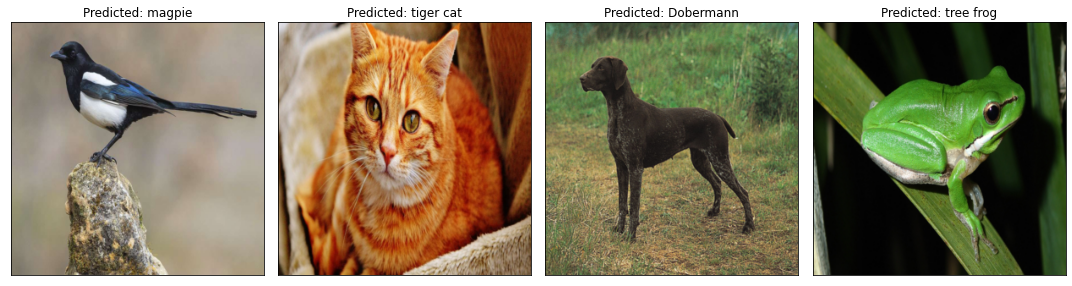

In [30]:
# load inception model 
model = inception_v3(pretrained=True) 
# set to eval, we don't want to modify it
model.eval()

# run the images through the model
output = model(imgs)
pred = torch.argmax(output, 1)

# visualisation
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))
for ax, img, p in zip(axes, imgs, pred):
    ax.imshow(np.transpose(img.detach(), (1,2,0)))
    ax.set_title(f"Predicted: {labels[p]}")
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()

In [49]:
# prepare loss function for the method
loss = nn.CrossEntropyLoss()

# eps parameter for the FGSM
eps = 0.2

# inputs need to have gradients enabled!
imgs.requires_grad = True

# run the model and calculate the loss
outputs = model(imgs)
cost = loss(outputs, pred)

# get input gradients
grad = torch.autograd.grad(cost, imgs, create_graph=False)[0]

# FGSM 
adv_imgs = imgs + eps * grad.sign()
# clamp to the image range
adv_imgs = torch.clamp(adv_imgs, min=0, max=1).detach()
# save gradients for visualisation
grads = torch.clamp(grad.sign(), min=0, max=1).detach()

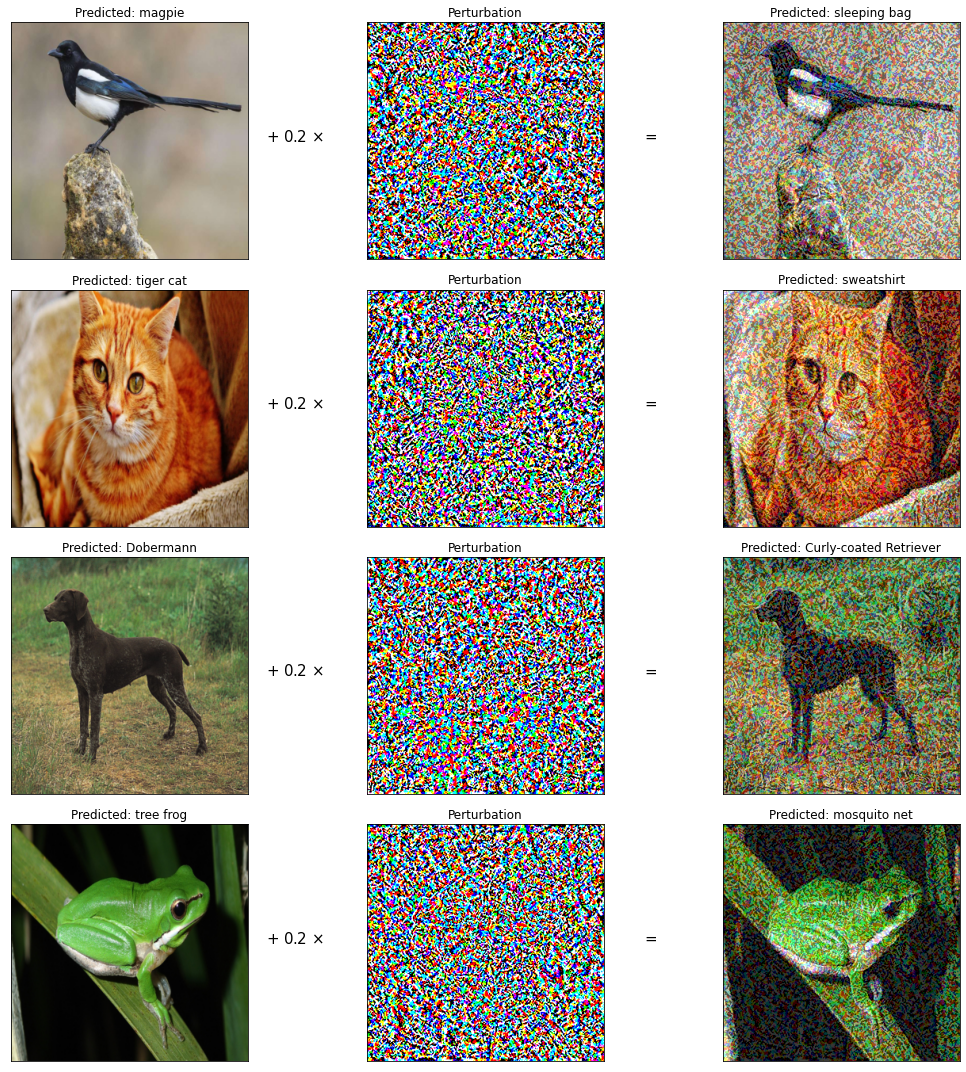

In [50]:
# run the advesarial samples through the network
output = model(adv_imgs)
adv_pred = torch.argmax(output, 1)

# visualisation
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
for row, img, adv, p, adv_p, g in zip(axes, imgs, adv_imgs, pred, adv_pred, grads):
    row[0].imshow(np.transpose(img.detach(), (1,2,0)))
    row[0].set_title(f"Predicted: {labels[p]}")
    row[0].set_xticks([])
    row[0].set_yticks([])
    
    row[0].text(1.2,0.5, fr"+ {eps} $\times$", size=15, ha="center", transform=row[0].transAxes)
    
    row[1].imshow(np.transpose(g, (1,2,0)))
    row[1].set_title(f"Perturbation")
    row[1].set_xticks([])
    row[1].set_yticks([])
    
    row[1].text(1.2,0.5, "=", size=15, ha="center", transform=row[1].transAxes)
    
    row[2].imshow(np.transpose(adv.detach(), (1,2,0)))
    row[2].set_title(f"Predicted: {labels[adv_p]}")
    row[2].set_xticks([])
    row[2].set_yticks([])
    
fig.tight_layout()

### Zadanie 3. Przykłady Adwersarialne (2 pkt.)
1. Zobacz dla jakiego $\epsilon$ metoda FGSM zmieni predykcje dla Sroki z powyższego przykładu.
2. Zastosuj metodę FGSM dla swojego modelu i 4 losowych przykładów z CIFAR10 tak aby uzyskać wizualizacje podobną do powyższej.

`HINT`: Normalizacja, której normalnie używamy sprawia, że obrazki wychodzą poza typowe $[0, 1]$, można rozwiązać ten problem na dwa sposoby: <br> 1) "odwrócić" normalizacje znając użyte średnią i odchylenie standardowe, <br> 2) nie używać normalizacji 

In [ ]:
# Predykcja dla sroki jest inna dla epsilon = 0.2

In [51]:
# tutaj załaduj 4 losowe przykłady ze zbioru testowego, uważaj na normalizacje!
import matplotlib.pyplot as plt

dataset = CIFAR10(root='.', train=True, transform=ToTensor())
loader = DataLoader(dataset, batch_size=4, shuffle=True)

for x, y in loader:
    break

In [52]:
# tutaj zastosuj metode FGSM do wygenerowania przykładów adwersarialnych
loss = nn.CrossEntropyLoss()
eps = 0.03

x.requires_grad = True

if cuda:
  x, y = x.cuda(), y.cuda()
outputs = net(x)
cost = loss(outputs, y)

# get input gradients
grad = torch.autograd.grad(cost, x, create_graph=False)[0]

# FGSM 
adv_imgs = x + eps * grad.sign()
# clamp to the image range
adv_imgs = torch.clamp(adv_imgs, min=0, max=1).detach()
# save gradients for visualisation
grads = torch.clamp(grad.sign(), min=0, max=1).detach()

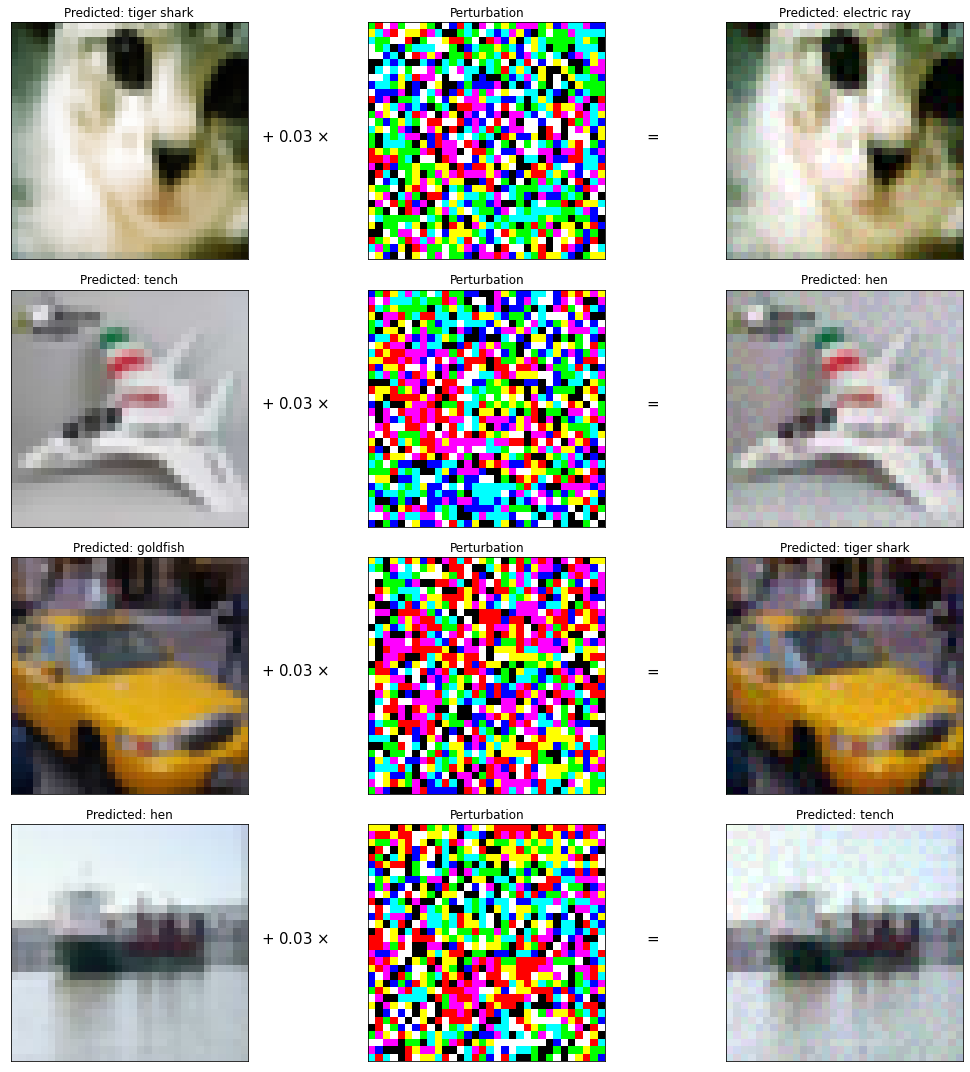

In [53]:
# tutaj przetestuj swój model i użyj wizualizacji z powyższego przykładu
output = net(adv_imgs)
adv_pred = torch.argmax(output, 1)

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
for row, img, adv, p, adv_p, g in zip(axes, x, adv_imgs, y, adv_pred, grads):
    row[0].imshow(np.transpose(img.cpu().detach(), (1,2,0)))
    row[0].set_title(f"Predicted: {labels[p]}")
    row[0].set_xticks([])
    row[0].set_yticks([])
    
    row[0].text(1.2,0.5, fr"+ {eps} $\times$", size=15, ha="center", transform=row[0].transAxes)
    
    row[1].imshow(np.transpose(g.cpu(), (1,2,0)))
    row[1].set_title(f"Perturbation")
    row[1].set_xticks([])
    row[1].set_yticks([])
    
    row[1].text(1.2,0.5, "=", size=15, ha="center", transform=row[1].transAxes)
    
    row[2].imshow(np.transpose(adv.cpu().detach(), (1,2,0)))
    row[2].set_title(f"Predicted: {labels[adv_p]}")
    row[2].set_xticks([])
    row[2].set_yticks([])
    
fig.tight_layout()